Code to calculate the total referrals for the pre- and post-implementation periods for services using the AI-enabled tool, match the services to most similar other services not using the tool and plot Figure 1 and perform the statistical tests.

In addition, it finds the demographic information for the treatment and control services and plot Figure 2 and perform statistical tests.

There is also an option to match on potential confounders, such as wait times, reliable recovery rates and the demographic information. If using the confounders, please note to change the method of matching to Mahlanobis distance (uncomment the neccessary lines).

In the end, there is also the analysis to check for the quality of matching (Supplementary Table 1)

In [45]:
import pandas as pd
import numpy as np
from datetime import date
import math
from scipy.stats import chi2_contingency 
import datetime
from dateutil.relativedelta import relativedelta as relativedelta
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import io
import sys
import scipy
from numpy.linalg import norm
import os
import glob
from iteration_utilities import deepflatten
import statsmodels.formula.api as smf
import statsmodels.api as sm

data_folder="/Users/johanna/Documents/GitHub/Limbic-increased-access/Annual_data/"

folder_figures_save='/Users/johanna/Library/CloudStorage/GoogleDrive-johanna@limbic.ai/Shared drives/05_Research/Publications (research papers)/Clinical/Increased_Access/Figures/'


## Combine and clean data

In [46]:
data_new=pd.read_csv(data_folder+'NHS_England_Feb-2022.csv', na_values = '*') #data from Feb 2021 to Feb 2022
data_old=pd.read_csv(data_folder+'NHS_England_Feb-2021.csv', na_values = '*') #data from Feb 2020 to Feb 2021
data_2 = pd.read_csv(data_folder +'iapt_time_series_aug_21_aug_22_key_measures.csv', na_values = '*') #data from Auguts 2021 to August 2022

data_all=pd.concat([data_new, data_old])
data_all=pd.concat([data_all, data_2])
data_all.drop_duplicates(inplace=True)

# change 'surrey iapt' to "mind matters surrey nhs" as their name was changed from March 2022
data_all.loc[data_all["ORG_NAME2"] == 'SURREY IAPT', 'ORG_NAME2'] = 'MIND MATTERS SURREY NHS'

In [47]:
#exclude services without webform

excluded = ['1POINT (NORTH WEST)', 'ISLE OF WIGHT NHS TRUST', 'THE BRIARY UNIT', 
 'TAMESIDE, OLDHAM AND GLOSSOP MIND', 'BLACKBURN CENTRE', 'SIX DEGREES SOCIAL ENTERPRISE CIC',
 'LIFT PSYCHOLOGY SWINDON', 'WEST ESSEX IAPT', 'THE NEWCASTLE UPON TYNE HOSPITALS NHS FOUNDATION TRUST',
 'BOOTHAM PARK HOSPITAL - ADMIN', 'FIELDHEAD HOSPITAL', 'ESSEX PARTNERSHIP UNIVERSITY NHS FOUNDATION TRUST',
'SOUTH TYNESIDE AND SUNDERLAND NHS FOUNDATION TRUST', 'MAKING SPACE']


data_all = data_all[~data_all['ORG_NAME2'].isin(excluded)]


In [48]:
# exclude services with missing data

excluded_2 = ['ROSANNE HOUSE', 'LGBT FOUNDATION', '360 CARE LTD', 'ACCESS SEFTON - BOOTLE', 'CITY AND HACKNEY MIND',
           'WRIGHTINGTON, WIGAN AND LEIGH NHS FOUNDATION TRUST', 'NORTH KENT MIND', 'COMMUNITY BARNET']

data_all = data_all[~data_all['ORG_NAME2'].isin(excluded_2)]


In [49]:
# load quaterly data for demographic information

data_folder="/Users/johanna/Documents/GitHub/Limbic-increased-access/Quaterly_data/"

#upload the data and merge
os.chdir(data_folder)
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

#combine all csv files
combined_csv = pd.concat([pd.read_csv(f, dtype = {'ProviderName': str}, na_values = '*') for f in all_filenames ]) 

# change 'surrey iapt' to "mind matters surrey nhs" as their name was changed from March 2022
combined_csv.loc[combined_csv["ProviderName"] == 'SURREY IAPT', 'ProviderName'] = 'MIND MATTERS SURREY NHS'

#exclude services without webform
combined_csv = combined_csv[~combined_csv['ProviderName'].isin(excluded)]
combined_csv = combined_csv[~combined_csv['ProviderName'].isin(excluded_2)]

#only include the referral data
data_referrals_demo = combined_csv[combined_csv['MEASURE_NAME'] == 'Count_ReferralsReceived']

#drop the total for all providers
data_referrals_demo = data_referrals_demo[~(data_referrals_demo['Provider'] == 'All_Provider')]

# replace nans for 1 service with the correct service name
data_referrals_demo.loc[data_referrals_demo['Provider'] == 'RTV', 'ProviderName'] = 'NORTH WEST BOROUGHS HEALTHCARE NHS FOUNDATION TRUST'


In [50]:
# load monthly data for recovery rates and wait times

data_folder = "/Users/johanna/Documents/GitHub/Limbic-increased-access/Monthly data"

os.chdir(data_folder)
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

#combine all csv files
combined_csv_monthly = pd.concat([pd.read_csv(f) for f in all_filenames ]) 

#combine all excel files
extension_excel = 'xlsx'
all_filenames_excel = [i for i in glob.glob('*.{}'.format(extension_excel))]
combined_excel = pd.concat([pd.read_excel(f, na_values = '*') for f in all_filenames_excel])

# change date format                                                  
combined_excel['REPORTING_PERIOD_START'] = combined_excel['REPORTING_PERIOD_START'].apply(lambda x: x.strftime('%d/%m/%Y'))
combined_excel['REPORTING_PERIOD_END'] = combined_excel['REPORTING_PERIOD_END'].apply(lambda x: x.strftime('%d/%m/%Y'))

#combine all
data_all_monthly = pd.concat([combined_csv_monthly, combined_excel])


# change 'surrey iapt' to "mind matters surrey nhs" as their name was changed from March 2022
data_all_monthly.loc[data_all_monthly["ORG_NAME2"] == 'SURREY IAPT', 'ORG_NAME2'] = 'MIND MATTERS SURREY NHS'

#combine data value columns
data_all_monthly['MEASURE_VALUE_SUPPRESSED'].update(data_all_monthly.pop('MEASURE_VALUE'))

#exclude services without webform
data_all_monthly = data_all_monthly[~data_all_monthly['ORG_NAME2'].isin(excluded)]
data_all_monthly = data_all_monthly[~data_all_monthly['ORG_NAME2'].isin(excluded_2)]


#exclude all totals
data_all_monthly = data_all_monthly[~(data_all_monthly['ORG_NAME2'] == 'all Providers')]

## only include rows of variables we are interested in 
data_all_monthly = data_all_monthly[data_all_monthly['MEASURE_NAME'].isin(['Count_ReferralsReceived', 'Count_SelfReferrals', 'Percentage_ReliableRecovery', 'Mean_WaitEnteredTreatment'])]


# change the name of the column to fit with the other datasets
data_all_monthly['MEASURE_VALUE'] = data_all_monthly['MEASURE_VALUE_SUPPRESSED']

## Define function to get demogrphic information

In [51]:
demographic_data = data_referrals_demo

def get_demographic_proportions(service, demographic_group, start_date):
    proportions = demographic_data[(demographic_data['ProviderName'] == service) &
                                   (demographic_data['VariableType'] == demographic_group) &
                                   (demographic_data['REPORTING_PERIOD_START'] == start_date)]
    if proportions.empty:
        if demographic_group == 'Ethnic Group':
            # Return NaN values for all ethnicity categories in the desired order
            categories = ['Asian or Asian British', 'Black or Black British', 'Mixed',
                          'Not stated/Not known/Invalid', 'Other Ethnic Groups', 'White']
            proportions = pd.DataFrame({'VariableA': categories})
        elif demographic_group == 'Gender':
            # Return NaN values for all gender categories in the desired order
            categories = ['Female', 'Indeterminate (unable to be classified as either male or female)',
                          'Male', 'Not stated/Not known/Invalid']
            proportions = pd.DataFrame({'VariableA': categories})
        elif demographic_group == 'Sexual Orientation':
            # Return NaN values for all sexual orientation categories in the desired order
            categories = ['Bi-sexual', 'Gay/Lesbian', 'Heterosexual', 'Not stated/Not known/Invalid']
            proportions = pd.DataFrame({'VariableA': categories})
        
        proportions['MEASURE_VALUE_SUPPRESSED'] = np.nan
        proportions['Referrals'] = np.nan
        proportions['Proportions'] = np.nan
    else:
        grouped_data = proportions.groupby('VariableA')['MEASURE_VALUE_SUPPRESSED'].sum().reset_index()
        categories = grouped_data['VariableA'].tolist()
        referrals = grouped_data['MEASURE_VALUE_SUPPRESSED'].tolist()
        proportions = pd.DataFrame({'VariableA': categories, 'Referrals': referrals})
        proportions['Proportions'] = proportions['Referrals'] / proportions['Referrals'].sum()
        proportions['Proportions'] = proportions['Proportions'].fillna(0)
        
        if demographic_group == 'Ethnic Group':
            # Check and insert NaN values for missing categories in the desired order
            expected_categories = ['Asian or Asian British', 'Black or Black British', 'Mixed',
                                   'Not stated/Not known/Invalid', 'Other Ethnic Groups', 'White']
        elif demographic_group == 'Gender':
            # Check and insert NaN values for missing categories in the desired order
            expected_categories = ['Female', 'Indeterminate (unable to be classified as either male or female)',
                                   'Male', 'Not stated/Not known/Invalid']
        elif demographic_group == 'Sexual Orientation':
            # Check and insert NaN values for missing categories in the desired order
            expected_categories = ['Bi-sexual', 'Gay/Lesbian', 'Heterosexual', 'Not stated/Not known/Invalid']
        
        proportions = proportions.reindex(columns=['VariableA', 'Referrals', 'Proportions'])
        proportions = proportions.set_index('VariableA').reindex(expected_categories).reset_index()
        
    return proportions['Referrals'].tolist(), proportions['Proportions'].tolist()


## Define functions to calculate total referral for services using the AI-enabled self-referral tool

In [52]:
# Definition to add nan values in a way where answer is nan if all values are nans
def sum_ignoring_nans(values):
    filtered_values = [val for val in values if not np.isnan(val)]

    if len(filtered_values) == 0:
        return np.nan
    else:
        return sum(filtered_values)

In [53]:
# Define functions -  added  recovery rates

#Function to calculate the total referrals and also the monthly referrals
def get_referral_sum(data_provider, dates_previous):  

    referrals_timeline=[]
    services_total = []
    services_names =[]
    recovery_timeline = []
    recovery_mean = []
    wait_time_timeline = []
    wait_time_mean = []
    self_referrals_timeline = []
    self_referrals_total = []

    for s in data_provider['ORG_NAME2'].unique(): #all services within one provider
        data_service=data_provider[data_provider['ORG_NAME2']==s]
        r=[]
        r_rec = []
        w = []
        self_r = []
        for d in dates_previous:  #dates for previous months
            data_months=data_service[data_service['REPORTING_PERIOD_START']==d]
            try: 
                arr=np.array(data_months['MEASURE_VALUE'][data_months['MEASURE_NAME']=='Count_ReferralsReceived']) #Count_SelfReferrals  Count_ReferralsReceived
                ref_months = int(arr[0])
                r.append(ref_months)
                
                arr_recovery = np.array(data_months['MEASURE_VALUE'][data_months['MEASURE_NAME'] == 'Percentage_ReliableRecovery'])
                recovery_months = float(arr_recovery[0])
                r_rec.append(recovery_months)
                
                mean_wait_time = np.array(data_months['MEASURE_VALUE'][data_months['MEASURE_NAME'] == 'Mean_WaitEnteredTreatment'])
                mean_wait_time_months = float(mean_wait_time[0])
                w.append(mean_wait_time_months)
                
                self_arr=np.array(data_months['MEASURE_VALUE'][data_months['MEASURE_NAME']=='Count_SelfReferrals']) #Count_SelfReferrals  Count_ReferralsReceived
                self_ref_months = int(self_arr[0])
                self_r.append(self_ref_months)
                
            except: 
                r.append(np.nan) 
                r_rec.append(np.nan)
                w.append(np.nan)
                self_r.append(np.nan)
                
        services_names.append(s) #name of service

        referrals_timeline.append(r) #referrals per month 
        services_total.append(sum(r)) #total referrals
        
        recovery_timeline.append(r_rec)
        recovery_mean.append(np.nanmean(r_rec))#mean recovery in the time period
        
        wait_time_timeline.append(w)
        wait_time_mean.append(np.nanmean(w)) #mean wait time in the time period
        
        self_referrals_timeline.append(self_r) #self referrals per month
        self_referrals_total.append(sum_ignoring_nans(self_r)) #total self referrals


    return services_names, services_total, referrals_timeline, recovery_mean, recovery_timeline, wait_time_timeline, wait_time_mean, self_referrals_timeline, self_referrals_total

#calculate the total and monthly referrals for pre and post perioud
def get_referral_rates(dates_previous, dates_after, data): 
    service, referrals_total_before, timeline_referrals_before, recovery_rates_before, recovery_timeline_before, wait_time_timeline_before, wait_time_mean_before,self_referrals_timeline_before, self_referrals_total_before = get_referral_sum(data, dates_previous)
    service, referrals_total_after, timeline_referrals_after, recovery_rates_after, recovery_timeline_after, wait_time_timeline_after, wait_time_mean_after, self_referrals_timeline_after, self_referrals_total_after  = get_referral_sum(data, dates_after)

    return service, referrals_total_before, referrals_total_after, timeline_referrals_before, timeline_referrals_after, recovery_rates_before, recovery_timeline_before, recovery_rates_after, recovery_timeline_after, wait_time_timeline_before, wait_time_mean_before, self_referrals_timeline_before, self_referrals_total_before

#find referal numbers for each service depending on their launch date
def get_referral_service(input_data, months = 0): 
    service_ind=[]
    service=input_data['service']
    for k in data_all_monthly['ORG_NAME2']: #tag the service
        if k.lower().startswith(service.lower()):
            service_ind.append(True)
        else: 
            service_ind.append(False)
    data_all_monthly['service_index']=np.array(service_ind)
    data_provider=data_all_monthly[data_all_monthly['service_index']==True]
    dt_object = datetime.datetime.strptime(input_data['start_date'],  "%d/%m/%Y") #date when services within the provider went live 
    dt_object2 = datetime.datetime.strptime(input_data['final_date'],  "%d/%m/%Y")
    diff=dt_object2-dt_object

    pre_dt_start = datetime.datetime.strptime(input_data['pre_start'],  "%d/%m/%Y") #pre period start date
    pre_dt_final = datetime.datetime.strptime(input_data['pre_final'],  "%d/%m/%Y") #pre period end date
    pre_diff = pre_dt_final - pre_dt_start

    date_after=[dt_object + relativedelta(months=i) for i in range(months, round(diff.days/30))]
    date_pre=[pre_dt_start + relativedelta(months=i) for i in range(months, round(pre_diff.days/30))]
    
    dates_after_string=[d.strftime("%d/%m/%Y").split(' ')[0] for d in date_after]
    dates_before_string=[d.strftime("%d/%m/%Y").split(' ')[0] for d in date_pre]

    return get_referral_rates(dates_before_string, dates_after_string,data_provider)


def find_all_referrals(months):
    output = []
    total_referrals_pre_post_tool = []
    average_referrals_pre_post_tool = []
    referral_timeline_tool_pre = []
    referral_timeline_tool_post = []
    recovery_rates_mean_pre = []
    recovery_rates_timeline_pre = []
    wait_time_timeline_pre = []
    wait_time_mean_pre = []
    self_referral_timeline_pre = []
    self_referral_total_pre = []
    service_name = []

    for i, input_data in enumerate(inputs_services):
        output = get_referral_service(input_data, months=months)
        service_name.append(output[0])
        total_referrals_pre_post_tool.append([output[1], output[2]])
        referral_timeline_tool_pre.append(output[3])
        referral_timeline_tool_post.append(output[4])
        recovery_rates_mean_pre.append(output[5])  # Add recovery rates in the pre-period
        recovery_rates_timeline_pre.append(output[6])
        
        wait_time_timeline_pre.append(output[9])
        wait_time_mean_pre.append(output[10])
        
        self_referral_timeline_pre.append(output[11])
        self_referral_total_pre.append(output[12])


    results = {
        'service': service_name,
        'total_referrals_pre_post_tool': total_referrals_pre_post_tool,
        'referral_timeline_tool_pre': referral_timeline_tool_pre,
        'referral_timeline_tool_post': referral_timeline_tool_post,
        'recovery_rates_pre_mean': recovery_rates_mean_pre,  # Include recovery rates in the pre-period
        'recovery_rates_pre_timeline': recovery_rates_timeline_pre,
        'wait_time_timeline_pre': wait_time_timeline_pre,
        'wait_time_mean_pre': wait_time_mean_pre,
        'self_referral_timeline_pre': self_referral_timeline_pre,
        'self_referral_total_pre': self_referral_total_pre
    }
 
    return results

## Define the services using the tool and the pre and post time periods

In [54]:
# Define the launch dates for services and a quarter before (3-months) and quarter after (3-months)

all_services=data_all_monthly['ORG_NAME2'].unique()

input_data_insight={"service":'insight',
    'start_date':'01/01/2022',
    'final_date':'01/04/2022',   #post period Q1 2022
    'pre_start': '01/07/2021',    
    'pre_final': '01/10/2021',    #pre period Q3 2021
} 

input_data_surrey={"service":'mind matters surrey nhs', #name was changed to "mind matters surrey nhs" from March 2022
    'start_date':'01/10/2021',
    'final_date':'01/01/2022',   # post period Q4 2021
    'pre_start': '01/04/2021',    
    'pre_final': '01/07/2021',    #pre period Q2 2021             
} 

input_data_trent={"service":'trent',
    'start_date':'01/10/2021',
    'final_date':'01/01/2022',   # post period Q4 2021
    'pre_start': '01/04/2021',    
    'pre_final': '01/07/2021',    #pre period Q2 2021             
                  
} 

input_data_vita={"service":'vita health',
    'start_date':'01/01/2021',   
    'final_date':'01/04/2021', # post period Q1 2021
    'pre_start': '01/10/2020',    
    'pre_final': '01/01/2021',    #pre period Q4 2020  
} 

inputs_services=[input_data_insight, input_data_surrey, input_data_trent, input_data_vita]

In [55]:
# Separate out service by service, rather than providers

input_data_insight_1={"service":'INSIGHT HEALTHCARE TALKING THERAPIES (PETERBOROUGH)',
    'start_date':'01/01/2022',
    'final_date':'01/04/2022',   #post period Q1 2022
    'pre_start': '01/07/2021',    
    'pre_final': '01/10/2021',    #pre period Q3 2021
}

input_data_insight_2={"service":'INSIGHT HEALTHCARE TALKING THERAPIES (KENT & MEDWAY)',
    'start_date':'01/01/2022',
    'final_date':'01/04/2022',   #post period Q1 2022
    'pre_start': '01/07/2021',    
    'pre_final': '01/10/2021',    #pre period Q3 2021
}

input_data_insight_3={"service":'INSIGHT HEALTHCARE - NOTTINGHAM CITY',
    'start_date':'01/01/2022',
    'final_date':'01/04/2022',   #post period Q1 2022
    'pre_start': '01/07/2021',    
    'pre_final': '01/10/2021',    #pre period Q3 2021
}

input_data_insight_4={"service":'INSIGHT HEALTHCARE - NOTTINGHAMSHIRE',
    'start_date':'01/01/2022',
    'final_date':'01/04/2022',   #post period Q1 2022
    'pre_start': '01/07/2021',    
    'pre_final': '01/10/2021',    #pre period Q3 2021
}

input_data_insight_5={"service":'INSIGHT HEALTHCARE - DERBYSHIRE',
    'start_date':'01/01/2022',
    'final_date':'01/04/2022',   #post period Q1 2022
    'pre_start': '01/07/2021',    
    'pre_final': '01/10/2021',    #pre period Q3 2021
}

input_data_insight_6={"service":'INSIGHT HEALHTCARE TALKING THERAPIES (BASSETLAW)',
    'start_date':'01/01/2022',
    'final_date':'01/04/2022',   #post period Q1 2022
    'pre_start': '01/07/2021',    
    'pre_final': '01/10/2021',    #pre period Q3 2021
}

input_data_insight_7={"service":'INSIGHT HEALTHCARE MID NOTTINGHAMSHIRE',
    'start_date':'01/01/2022',
    'final_date':'01/04/2022',   #post period Q1 2022
    'pre_start': '01/07/2021',    
    'pre_final': '01/10/2021',    #pre period Q3 2021
}

input_data_surrey={"service":'MIND MATTERS SURREY NHS', #name was changed to "mind matters surrey nhs" from March 2022
    'start_date':'01/10/2021',
    'final_date':'01/01/2022',   # post period Q4 2021
    'pre_start': '01/04/2021',    
    'pre_final': '01/07/2021',    #pre period Q2 2021   
}

input_data_trent={"service":'TRENT PTS',
    'start_date':'01/10/2021',
    'final_date':'01/01/2022',   # post period Q4 2021
    'pre_start': '01/04/2021',    
    'pre_final': '01/07/2021',    #pre period Q2 2021   
}  

input_data_vita_1={"service":'VITA HEALTH GROUP: VITA MINDS BASILDON & BRENTWOOD',
    'start_date':'01/01/2021',   
    'final_date':'01/04/2021', # post period Q1 2021
    'pre_start': '01/10/2020',    
    'pre_final': '01/01/2021',    #pre period Q4 2020  
} 

input_data_vita_2 ={"service":'VITA HEALTH GROUP: VITAMINDS BRISTOL, NORTH SOMERSET & SOUTH GLOUCESTERSHIRE',
    'start_date':'01/01/2021',   
    'final_date':'01/04/2021', # post period Q1 2021
    'pre_start': '01/10/2020',    
    'pre_final': '01/01/2021',    #pre period Q4 2020  
} 
   
input_data_vita_3 ={"service":'VITA HEALTH GROUP: VITAMINDS DARTFORD',
    'start_date':'01/01/2021',   
    'final_date':'01/04/2021', # post period Q1 2021
    'pre_start': '01/10/2020',    
    'pre_final': '01/01/2021',    #pre period Q4 2020  
} 

input_data_vita_4 ={"service":'VITA HEALTH GROUP: VITAMINDS DERBY',
    'start_date':'01/01/2021',   
    'final_date':'01/04/2021', # post period Q1 2021
    'pre_start': '01/10/2020',    
    'pre_final': '01/01/2021',    #pre period Q4 2020  
} 
   
input_data_vita_5 ={"service":'VITA HEALTH GROUP: VITAMINDS CALDERDALE',
    'start_date':'01/01/2021',   
    'final_date':'01/04/2021', # post period Q1 2021
    'pre_start': '01/10/2020',    
    'pre_final': '01/01/2021',    #pre period Q4 2020  
} 

inputs_services_separate = [input_data_insight_1, input_data_insight_2, input_data_insight_3, input_data_insight_4, 
                            input_data_insight_5, input_data_insight_6, input_data_insight_7, input_data_surrey,
                            input_data_trent, input_data_vita_1, input_data_vita_2, input_data_vita_3,
                            input_data_vita_4, input_data_vita_5]


## Find total referrals for the services using the tool and the demographic proporitons

In [56]:
# find referrals to all the services using the AI-enabled self-referral tool
results = find_all_referrals(0)

/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:53: RuntimeWarning: Mean of empty slice
  recovery_mean.append(np.nanmean(r_rec))#mean recovery in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:56: RuntimeWarning: Mean of empty slice
  wait_time_mean.append(np.nanmean(w)) #mean wait time in the time period


In [57]:
# Run the demographic function for services using the tool

# pre period

results_tool_demographic_pre = {}

for input_data in inputs_services_separate:
    service = input_data['service']
    start_date = input_data['pre_start']
    ethnicity_referrals, ethnicity_proportions = get_demographic_proportions(service, 'Ethnic Group', start_date)
    gender_referrals, gender_proportions = get_demographic_proportions(service, 'Gender', start_date)
    sexual_orientation_referrals, sexual_orientation_proportions = get_demographic_proportions(service, 'Sexual Orientation', start_date)
    
    results_tool_demographic_pre[service] = {
        'Ethnicity': {
            'Referrals': ethnicity_referrals,
            'Proportions': ethnicity_proportions},
        'Gender': {
            'Referrals': gender_referrals,
            'Proportions': gender_proportions},
        'Sexual Orientation': {
            'Referrals': sexual_orientation_referrals,
            'Proportions': sexual_orientation_proportions}}
    
    
#post period
results_tool_demographic_post = {}

for input_data in inputs_services_separate:
    service = input_data['service']
    start_date = input_data['start_date']
    ethnicity_referrals, ethnicity_proportions = get_demographic_proportions(service, 'Ethnic Group', start_date)
    gender_referrals, gender_proportions = get_demographic_proportions(service, 'Gender', start_date)
    sexual_orientation_referrals, sexual_orientation_proportions = get_demographic_proportions(service, 'Sexual Orientation', start_date)
    
    results_tool_demographic_post[service] = {
        'Ethnicity': {
            'Referrals': ethnicity_referrals,
            'Proportions': ethnicity_proportions},
        'Gender': {
            'Referrals': gender_referrals,
            'Proportions': gender_proportions},
        'Sexual Orientation': {
            'Referrals': sexual_orientation_referrals,
            'Proportions': sexual_orientation_proportions}}

In [58]:
# Define the demographic groups
ethnic_groups = ['Asian or Asian British', 'Black or Black British', 'Mixed', 'Not stated/Not known/Invalid', 'Other Ethnic Groups', 'White']
genders = ['Female', 'Indeterminate (unable to be classified as either male or female)', 'Male', 'Not stated/Not known/Invalid']
sexual_orientations = ['Bi-sexual', 'Gay/Lesbian', 'Heterosexual', 'Not stated/Not known/Invalid']

# Calculate the total referrals for each subgroup
ethnicity_total_pre = [sum([data['Ethnicity']['Referrals'][i] for data in results_tool_demographic_pre.values()]) for i in range(len(ethnic_groups))]
ethnicity_total_post = [np.nansum([data['Ethnicity']['Referrals'][i] for data in results_tool_demographic_post.values()]) for i in range(len(ethnic_groups))]
ethnicity_change = [post - pre for post, pre in zip(ethnicity_total_post, ethnicity_total_pre)]

gender_total_pre = [sum([data['Gender']['Referrals'][i] for data in results_tool_demographic_pre.values()]) for i in range(len(genders))]
gender_total_post = [np.nansum([data['Gender']['Referrals'][i] for data in results_tool_demographic_post.values()]) for i in range(len(genders))]
gender_change = [post - pre for post, pre in zip(gender_total_post, gender_total_pre)]

sexuality_total_pre = [sum([data['Sexual Orientation']['Referrals'][i] for data in results_tool_demographic_pre.values()]) for i in range(len(sexual_orientations))]
sexuality_total_post = [np.nansum([data['Sexual Orientation']['Referrals'][i] for data in results_tool_demographic_post.values()]) for i in range(len(sexual_orientations))]
sexuality_change = [post - pre for post, pre in zip(sexuality_total_post, sexuality_total_pre)]


# Calculate the percentage change for each subgroup
ethnicity_perc_change =  [(change / pre) * 100 for change, pre in zip(ethnicity_change, ethnicity_total_pre)]
gender_perc_change =  [(change / pre) * 100 for change, pre in zip(gender_change, gender_total_pre)]
sexuality_perc_change =  [(change / pre) * 100 for change, pre in zip(sexuality_change, sexuality_total_pre)]

## Find matches for services

In [61]:
#match services - added demographic proportions in the per period 

text_trap = io.StringIO()
sys.stdout = text_trap

percentag_IAPT=1

service_compare=[]
distance_compare=[]
direction_compare=[]
pre_referrals_compare = []
post_referrals_compare = []
output=[]
pre_timeline_compare = []
post_timeline_comapre = []
ethnicity_proportions_compare = []
gender_proportions_compare = []
sexuality_proportions_compare = []
ethnicity_referrals_compare = []
gender_referrals_compare = []
sexuality_referrals_compare = []
ethnicity_proportions_post_compare = []
gender_proportions_post_compare = []
sexuality_proportions_post_compare = []
ethnicity_referrals_post_compare = []
gender_referrals_post_compare = []
sexuality_referrals_post_compare = []
recovery_pre_mean_compare = []
recovery_pre_timeline_compare = []

waitlines_pre_mean_compare = []
waitlines_pre_timeline_compare = []
self_ref_pre_total_compare = []
self_ref_pre_timelines_compare = []

for i, input_data_tool in enumerate(inputs_services_separate): #for every service
    vector_comparison=[]
    service_id=[]
    pre_referral = []
    post_referral = []
    pre_timelines = []
    post_timelines = []
    ethnicity_proportions_list = []
    gender_proportions_list = []
    sexuality_proportions_list = []
    ethnicity_referrals_list = []
    gender_referrals_list = []
    sexuality_referrals_list = []
    ethnicity_proportions_post_list = []
    gender_proportions_post_list = []
    sexuality_proportions_post_list = []
    ethnicity_referrals_post_list = []
    gender_referrals_post_list = []
    sexuality_referrals_post_list = []
    pre_recovery_mean = []
    pre_recovery_timelines = []
    
    pre_waittime_mean = []
    pre_waittime_timelines = []
    
    pre_self_ref_total = []
    pre_self_ref_timelines = []
    
    output = get_referral_service(input_data_tool) #return service, referrals_total_before, referrals_total_after, timeline_referrals_before, timeline_referrals_after
    pre_total_referrals = output[1][0]
    post_total_referrals = output[2][0]
    pre_timeline = output[3][0] #timelines to check that there are no missing months
    post_timeline = output[4][0] #timelines to check that there are no missing months
    
    pre_recovery_rates = output[5][0]
    pre_recovery_rates_timeline = output[6][0]
    
    pre_waittime = output[10][0]
    pre_waittime_timeline = output[9][0]
    
    pre_self_referrals_total = output[12][0]
    pre_self_referrals_timeline = output[11][0]
    
    service_id.append(output[0][0])
    pre_referral.append(pre_total_referrals)
    post_referral.append(post_total_referrals)
    pre_timelines.append(pre_timeline)
    post_timelines.append(post_timeline)
    
    pre_recovery_mean.append(pre_recovery_rates)
    pre_recovery_timelines.append(pre_recovery_rates_timeline)
    
    pre_waittime_mean.append(pre_waittime)
    pre_waittime_timelines.append(pre_waittime_timeline)
    
    pre_self_ref_total.append(pre_self_referrals_total)
    pre_self_ref_timelines.append(pre_self_referrals_timeline)
        
    # Get demographic proportions for the current service - pre period
    ethnicity_referrals, ethnicity_proportions = get_demographic_proportions(input_data_tool['service'], 'Ethnic Group', input_data_tool['pre_start'])
    gender_referrals, gender_proportions = get_demographic_proportions(input_data_tool['service'], 'Gender', input_data_tool['pre_start'])
    sexuality_referrals, sexuality_proportions = get_demographic_proportions(input_data_tool['service'], 'Sexual Orientation', input_data_tool['pre_start'])    
    
    ethnicity_proportions_list.append(ethnicity_proportions)
    gender_proportions_list.append(gender_proportions)
    sexuality_proportions_list.append(sexuality_proportions)

    ethnicity_referrals_list.append(ethnicity_referrals)
    gender_referrals_list.append(gender_referrals)
    sexuality_referrals_list.append(sexuality_referrals)
    
    # Get demographic proportions for the current service - post period
    ethnicity_referrals_post, ethnicity_proportions_post = get_demographic_proportions(input_data_tool['service'], 'Ethnic Group', input_data_tool['start_date'])
    gender_referrals_post, gender_proportions_post = get_demographic_proportions(input_data_tool['service'], 'Gender', input_data_tool['start_date'])
    sexuality_referrals_post, sexuality_proportions_post = get_demographic_proportions(input_data_tool['service'], 'Sexual Orientation', input_data_tool['start_date'])    
    
    ethnicity_proportions_post_list.append(ethnicity_proportions_post)
    gender_proportions_post_list.append(gender_proportions_post)
    sexuality_proportions_post_list.append(sexuality_proportions_post)

    ethnicity_referrals_post_list.append(ethnicity_referrals_post)
    gender_referrals_post_list.append(gender_referrals_post)
    sexuality_referrals_post_list.append(sexuality_referrals_post)

    #vector for matching -  total referrals and  demographic details 
#     vector_comparison.append(list(deepflatten([pre_total_referrals, sexuality_referrals, gender_referrals, ethnicity_referrals], depth=1)))

    #vector for matching -  total referrals and  reliable recovery and wait times 
#     vector_comparison.append(list(deepflatten([pre_total_referrals, pre_recovery_rates, pre_waittime], depth=1)))

    # vector for matching - only total referrals
    vector_comparison.append(list(deepflatten([pre_total_referrals], depth=1))) 


    for i, input_data in enumerate(all_services): 
        if  (input_data.lower().startswith('city and hackney mind')==False) & (input_data.lower().startswith('access sefton')==False) & (input_data.lower().startswith('360 care ltd')==False) &(input_data.lower().startswith('lgbt foundation')==False) & (input_data.lower().startswith('rosanne house')==False) & (input_data.lower().startswith('community barnet')==False) &(input_data.lower().startswith('wrightington, wigan and leigh nhs foundation trust')==False) &(input_data.lower().startswith('north kent mind')==False) & (input_data.lower().startswith('we are with you in reigate')==False) & (input_data.lower().startswith('insight')==False) & (input_data.lower().startswith('trent')==False) & (input_data.lower().startswith('vita health')==False) & (input_data.lower().startswith('mind matters surrey nhs')==False)& (input_data.lower().startswith('nottinghamshire healthcare nhs foundation trust')==False)&(input_data.lower().startswith('all providers')==False): 
            output=get_referral_service({'service': input_data.lower(), 'start_date': input_data_tool['start_date'], 'final_date': input_data_tool['final_date'], 'pre_start': input_data_tool['pre_start'],'pre_final': input_data_tool['pre_final']})

            pre_total_referrals = output[1][0]
            post_total_referrals = output[2][0]
            pre_timeline = output[3][0] #timelines to check that there are no missing months
            post_timeline = output[4][0] #timelines to check that there are no missing months
            pre_recovery_rates = output[5][0]
            pre_recovery_rates_timeline = output[6][0]
            pre_waittime = output[10][0]
            pre_waittime_timeline = output[9][0]  
            pre_self_referrals_total = output[12][0]
            pre_self_referrals_timeline = output[11][0]
            
            service_id.append(input_data)
            pre_referral.append(pre_total_referrals) #combine the tool pre total referrals with all other referrals at the same time period
            post_referral.append(post_total_referrals)
            pre_timelines.append(pre_timeline)
            post_timelines.append(post_timeline)
            
            # recovery
            pre_recovery_mean.append(pre_recovery_rates)
            pre_recovery_timelines.append(pre_recovery_rates_timeline)
            
            # waittimes
            pre_waittime_mean.append(pre_waittime)
            pre_waittime_timelines.append(pre_waittime_timeline)
            
            #self referrals
            pre_self_ref_total.append(pre_self_referrals_total)
            pre_self_ref_timelines.append(pre_self_referrals_timeline)
            
            # Get demographic proportions for the services - pre period
            ethnicity_referrals, ethnicity_proportions = get_demographic_proportions(input_data, 'Ethnic Group', input_data_tool['pre_start'])
            gender_referrals, gender_proportions = get_demographic_proportions(input_data, 'Gender', input_data_tool['pre_start'])
            sexuality_referrals, sexuality_proportions = get_demographic_proportions(input_data, 'Sexual Orientation', input_data_tool['pre_start'])        
    
            ethnicity_proportions_list.append(ethnicity_proportions)
            gender_proportions_list.append(gender_proportions)
            sexuality_proportions_list.append(sexuality_proportions)
            
            ethnicity_referrals_list.append(ethnicity_referrals)
            gender_referrals_list.append(gender_referrals)
            sexuality_referrals_list.append(sexuality_referrals)
            
            # Get demographic proportions for the services - post period
            ethnicity_referrals_post, ethnicity_proportions_post = get_demographic_proportions(input_data, 'Ethnic Group', input_data_tool['start_date'])
            gender_referrals_post, gender_proportions_post = get_demographic_proportions(input_data, 'Gender', input_data_tool['start_date'])
            sexuality_referrals_post, sexuality_proportions_post = get_demographic_proportions(input_data, 'Sexual Orientation', input_data_tool['start_date'])    

            ethnicity_proportions_post_list.append(ethnicity_proportions_post)
            gender_proportions_post_list.append(gender_proportions_post)
            sexuality_proportions_post_list.append(sexuality_proportions_post)

            ethnicity_referrals_post_list.append(ethnicity_referrals_post)
            gender_referrals_post_list.append(gender_referrals_post)
            sexuality_referrals_post_list.append(sexuality_referrals_post)
            
                #vector for matching -  total referrals and  demographic details 
#             vector_comparison.append(list(deepflatten([pre_total_referrals, sexuality_referrals, gender_referrals, ethnicity_referrals], depth=1)))

            #vector for matching -  total referrals and  reliable recovery and wait times 
        #     vector_comparison.append(list(deepflatten([pre_total_referrals, pre_recovery_rates, pre_waittime], depth=1)))

            # vector for matching - only total referrals
            vector_comparison.append(list(deepflatten([pre_total_referrals], depth=1))) 
            

        else: 
            print(input_data)
            
            
    vector_comparison=np.array(vector_comparison)
    normalised_vector_comparison=scipy.stats.zscore(vector_comparison, axis = 0, nan_policy = 'omit') #normalise the values
    
    
    #calculate covariance for mahalanobis distance - comment when using the euclidean distance
#     vector_comparison_nonans = vector_comparison[~np.isnan(vector_comparison).any(axis=1)]     
#     cm = np.cov(vector_comparison_nonans, rowvar=False)
#     icm = np.linalg.inv(cm) #inverse covariate matrix
    
    
    distance=[]
    service=[]
    input_matrix=[]
    for i in range(normalised_vector_comparison.shape[0]): 

        #euclidean distance - comment when using the mahalanobis distance
        distance.append(norm(normalised_vector_comparison[0, :]-normalised_vector_comparison[i, :]))

        #mahalanobis distance - comment when using the euclidean distance
#         distance.append(scipy.spatial.distance.mahalanobis(vector_comparison[0, :], vector_comparison[i, :],icm))
        
        service.append(service_id[i])        
        input_matrix.append(vector_comparison[i, :])

    sorted_distance=pd.DataFrame({'service': service, 'distance':distance, 'input_matrix':input_matrix,
                                'initial_referrals':pre_referral,'post_referrals': post_referral, #     'direction':vector_comparison[0, 0]-vector_comparison[:, 0], 
                                 'pre_timelines': pre_timelines, 'post_timelines': post_timelines,
                                 'ethnicity_proportions': ethnicity_proportions_list,
                                 'gender_proportions': gender_proportions_list,
                                 'sexuality_proportions': sexuality_proportions_list,
                                 'ethnicity_referrals': ethnicity_referrals_list,
                                 'gender_referrals': gender_referrals_list,
                                 'sexuality_referrals': sexuality_referrals_list,
                                 'ethnicity_proportions_post': ethnicity_proportions_post_list,
                                 'gender_proportions_post': gender_proportions_post_list,
                                 'sexuality_proportions_post': sexuality_proportions_post_list,
                                 'ethnicity_referrals_post': ethnicity_referrals_post_list,
                                 'gender_referrals_post': gender_referrals_post_list,
                                 'sexuality_referrals_post': sexuality_referrals_post_list,
                                 'recovery_pre_mean': pre_recovery_mean,
                                 'recovery_pre_timelines': pre_recovery_timelines,
                                 'waittimes_pre_mean': pre_waittime_mean,
                                 'waittimes_pre_timelines': pre_waittime_timelines,
                                 'self_referral_total': pre_self_ref_total,
                                 'self_referral_timeline': pre_self_ref_timelines})  

    sorted_distance=sorted_distance.sort_values(by='distance')
    
    if percentag_IAPT==5: #find the k  closest services
        k = 5
        service_include=[sorted_distance['service'][sorted_distance['direction']>0].iloc[:k], sorted_distance['service'][sorted_distance['direction']<0].iloc[:k]]
        distance_include=[sorted_distance['distance'][sorted_distance['direction']>0].iloc[:k], sorted_distance['distance'][sorted_distance['direction']<0].iloc[:k]]
#         direction_include=[sorted_distance['direction'][sorted_distance['direction']>0].iloc[:k], sorted_distance['direction'][sorted_distance['direction']<0].iloc[:k]] 
        pre_referrals_include= [sorted_distance['initial_referrals'][sorted_distance['direction']>0].iloc[:k], sorted_distance['initial_referrals'][sorted_distance['direction']<0].iloc[:k]] 
        post_referrals_include =[sorted_distance['post_referrals'][sorted_distance['direction']>0].iloc[:k], sorted_distance['post_referrals'][sorted_distance['direction']<0].iloc[:k]] 
        pre_timeline_include = [sorted_distance['pre_timelines'][sorted_distance['direction']>0].iloc[:k], sorted_distance['pre_timelines'][sorted_distance['direction']<0].iloc[:k]] 
        post_timeline_include= [sorted_distance['post_timelines'][sorted_distance['direction']>0].iloc[:k], sorted_distance['post_timelines'][sorted_distance['direction']<0].iloc[:k]] 
    elif percentag_IAPT==1: #match to the closest service
        service_include=[sorted_distance['service'].iloc[1]]
        distance_include=[sorted_distance['distance'].iloc[1]]
#         direction_include=[sorted_distance['direction'].iloc[1]]
        pre_referrals_include = [sorted_distance['initial_referrals'].iloc[1]]
        post_referrals_include = [sorted_distance['post_referrals'].iloc[1]]
        pre_timeline_include = [sorted_distance['pre_timelines'].iloc[1]]
        post_timeline_include = [sorted_distance['post_timelines'].iloc[1]]
        ethnicity_include = [sorted_distance['ethnicity_proportions'].iloc[1]]
        gender_include = [sorted_distance['gender_proportions'].iloc[1]]
        sexuality_include = [sorted_distance['sexuality_proportions'].iloc[1]]
        ethnicity_ref_include = [sorted_distance['ethnicity_referrals'].iloc[1]]
        gender_ref_include = [sorted_distance['gender_referrals'].iloc[1]]
        sexuality_ref_include = [sorted_distance['sexuality_referrals'].iloc[1]]
        ethnicity_include_post = [sorted_distance['ethnicity_proportions_post'].iloc[1]]
        gender_include_post = [sorted_distance['gender_proportions_post'].iloc[1]]
        sexuality_include_post = [sorted_distance['sexuality_proportions_post'].iloc[1]]
        ethnicity_ref_include_post = [sorted_distance['ethnicity_referrals_post'].iloc[1]]
        gender_ref_include_post = [sorted_distance['gender_referrals_post'].iloc[1]]
        sexuality_ref_include_post = [sorted_distance['sexuality_referrals_post'].iloc[1]]
        pre_recvoery_mean_include = [sorted_distance['recovery_pre_mean'].iloc[1]]
        pre_recvoery_timeline_include = [sorted_distance['recovery_pre_timelines'].iloc[1]]
        pre_waittime_mean_include = [sorted_distance['waittimes_pre_mean'].iloc[1]]
        pre_waittime_timeline_include = [sorted_distance['waittimes_pre_timelines'].iloc[1]]
        pre_self_ref_total_include = [sorted_distance['self_referral_total'].iloc[1]]
        pre_self_ref_timeline_include = [sorted_distance['self_referral_timeline'].iloc[1]]
    
    if percentag_IAPT==1:
        #if the service has been already included in service_compare, then take the 2nd option.
        if service_include in service_compare:
            service_include=[sorted_distance['service'].iloc[2]]
            distance_include=[sorted_distance['distance'].iloc[2]]
#             direction_include=[sorted_distance['direction'].iloc[2]]
            pre_referrals_include = [sorted_distance['initial_referrals'].iloc[2]]
            post_referrals_include = [sorted_distance['post_referrals'].iloc[2]]
            pre_timeline_include = [sorted_distance['pre_timelines'].iloc[2]]
            post_timeline_include = [sorted_distance['post_timelines'].iloc[2]]
            ethnicity_include = [sorted_distance['ethnicity_proportions'].iloc[2]]
            gender_include = [sorted_distance['gender_proportions'].iloc[2]]
            sexuality_include = [sorted_distance['sexuality_proportions'].iloc[2]]
            ethnicity_ref_include = [sorted_distance['ethnicity_referrals'].iloc[2]]
            gender_ref_include = [sorted_distance['gender_referrals'].iloc[2]]
            sexuality_ref_include = [sorted_distance['sexuality_referrals'].iloc[2]]
            ethnicity_include_post = [sorted_distance['ethnicity_proportions_post'].iloc[2]]
            gender_include_post = [sorted_distance['gender_proportions_post'].iloc[2]]
            sexuality_include_post = [sorted_distance['sexuality_proportions_post'].iloc[2]]
            ethnicity_ref_include_post = [sorted_distance['ethnicity_referrals_post'].iloc[2]]
            gender_ref_include_post = [sorted_distance['gender_referrals_post'].iloc[2]]
            sexuality_ref_include_post = [sorted_distance['sexuality_referrals_post'].iloc[2]]
            pre_recvoery_mean_include = [sorted_distance['recovery_pre_mean'].iloc[2]]
            pre_recvoery_timeline_include = [sorted_distance['recovery_pre_timelines'].iloc[2]]
            pre_waittime_mean_include = [sorted_distance['waittimes_pre_mean'].iloc[2]]
            pre_waittimee_waittime_timeline_include = [sorted_distance['waittimes_pre_timelines'].iloc[2]]
            pre_self_ref_total_include = [sorted_distance['self_referral_total'].iloc[2]]
            pre_self_ref_timeline_include = [sorted_distance['self_referral_timeline'].iloc[2]]
            if service_include in service_compare:
                service_include=[sorted_distance['service'].iloc[3]]
                distance_include=[sorted_distance['distance'].iloc[3]]
#                 direction_include=[sorted_distance['direction'].iloc[3]]
                pre_referrals_include = [sorted_distance['initial_referrals'].iloc[3]]
                post_referrals_include = [sorted_distance['post_referrals'].iloc[3]]
                pre_timeline_include = [sorted_distance['pre_timelines'].iloc[3]]
                post_timeline_include = [sorted_distance['post_timelines'].iloc[3]]
                ethnicity_include = [sorted_distance['ethnicity_proportions'].iloc[3]]
                gender_include = [sorted_distance['gender_proportions'].iloc[3]]
                sexuality_include = [sorted_distance['sexuality_proportions'].iloc[3]]
                ethnicity_ref_include = [sorted_distance['ethnicity_referrals'].iloc[3]]
                gender_ref_include = [sorted_distance['gender_referrals'].iloc[3]]
                sexuality_ref_include = [sorted_distance['sexuality_referrals'].iloc[3]]
                ethnicity_include_post = [sorted_distance['ethnicity_proportions_post'].iloc[3]]
                gender_include_post = [sorted_distance['gender_proportions_post'].iloc[3]]
                sexuality_include_post = [sorted_distance['sexuality_proportions_post'].iloc[3]]
                ethnicity_ref_include_post = [sorted_distance['ethnicity_referrals_post'].iloc[3]]
                gender_ref_include_post = [sorted_distance['gender_referrals_post'].iloc[3]]
                sexuality_ref_include_post = [sorted_distance['sexuality_referrals_post'].iloc[3]]
                pre_recvoery_mean_include = [sorted_distance['recovery_pre_mean'].iloc[3]]
                pre_recvoery_timeline_include = [sorted_distance['recovery_pre_timelines'].iloc[3]]
                pre_waittime_mean_include = [sorted_distance['waittimes_pre_mean'].iloc[3]]
                pre_waittime_timeline_include = [sorted_distance['waittimes_pre_timelines'].iloc[3]]
                pre_self_ref_total_include = [sorted_distance['self_referral_total'].iloc[3]]
                pre_self_ref_timeline_include = [sorted_distance['self_referral_timeline'].iloc[3]]
                if service_include in service_compare:
                    service_include=[sorted_distance['service'].iloc[4]]
                    distance_include=[sorted_distance['distance'].iloc[4]]
#                     direction_include=[sorted_distance['direction'].iloc[4]]
                    pre_referrals_include = [sorted_distance['initial_referrals'].iloc[4]]
                    post_referrals_include = [sorted_distance['post_referrals'].iloc[4]]
                    pre_timeline_include = [sorted_distance['pre_timelines'].iloc[4]]
                    post_timeline_include = [sorted_distance['post_timelines'].iloc[4]]
                    ethnicity_include = [sorted_distance['ethnicity_proportions'].iloc[4]]
                    gender_include = [sorted_distance['gender_proportions'].iloc[4]]
                    sexuality_include = [sorted_distance['sexuality_proportions'].iloc[4]]
                    ethnicity_ref_include = [sorted_distance['ethnicity_referrals'].iloc[4]]
                    gender_ref_include = [sorted_distance['gender_referrals'].iloc[4]]
                    sexuality_ref_include = [sorted_distance['sexuality_referrals'].iloc[4]]
                    ethnicity_include_post = [sorted_distance['ethnicity_proportions_post'].iloc[4]]
                    gender_include_post = [sorted_distance['gender_proportions_post'].iloc[4]]
                    sexuality_include_post = [sorted_distance['sexuality_proportions_post'].iloc[4]]
                    ethnicity_ref_include_post = [sorted_distance['ethnicity_referrals_post'].iloc[4]]
                    gender_ref_include_post = [sorted_distance['gender_referrals_post'].iloc[4]]
                    sexuality_ref_include_post = [sorted_distance['sexuality_referrals_post'].iloc[4]]
                    pre_recvoery_mean_include = [sorted_distance['recovery_pre_mean'].iloc[4]]
                    pre_recvoery_timeline_include = [sorted_distance['recovery_pre_timelines'].iloc[4]]
                    pre_waittime_mean_include = [sorted_distance['waittimes_pre_mean'].iloc[4]]
                    pre_waittime_timeline_include = [sorted_distance['waittimes_pre_timelines'].iloc[4]]
                    pre_self_ref_total_include = [sorted_distance['self_referral_total'].iloc[4]]
                    pre_self_ref_timeline_include = [sorted_distance['self_referral_timeline'].iloc[4]]
                    if service_include in service_compare:
                        service_include=[sorted_distance['service'].iloc[5]]
                        distance_include=[sorted_distance['distance'].iloc[5]]
#                         direction_include=[sorted_distance['direction'].iloc[5]]
                        pre_referrals_include = [sorted_distance['initial_referrals'].iloc[5]]
                        post_referrals_include = [sorted_distance['post_referrals'].iloc[5]]
                        pre_timeline_include = [sorted_distance['pre_timelines'].iloc[5]]
                        post_timeline_include = [sorted_distance['post_timelines'].iloc[5]]
                        ethnicity_include = [sorted_distance['ethnicity_proportions'].iloc[5]]
                        gender_include = [sorted_distance['gender_proportions'].iloc[5]]
                        sexuality_include = [sorted_distance['sexuality_proportions'].iloc[5]]
                        ethnicity_ref_include = [sorted_distance['ethnicity_referrals'].iloc[5]]
                        gender_ref_include = [sorted_distance['gender_referrals'].iloc[5]]
                        sexuality_ref_include = [sorted_distance['sexuality_referrals'].iloc[5]]
                        ethnicity_include_post = [sorted_distance['ethnicity_proportions_post'].iloc[5]]
                        gender_include_post = [sorted_distance['gender_proportions_post'].iloc[5]]
                        sexuality_include_post = [sorted_distance['sexuality_proportions_post'].iloc[5]]
                        ethnicity_ref_include_post = [sorted_distance['ethnicity_referrals_post'].iloc[5]]
                        gender_ref_include_post = [sorted_distance['gender_referrals_post'].iloc[5]]
                        sexuality_ref_include_post = [sorted_distance['sexuality_referrals_post'].iloc[5]]
                        pre_recvoery_mean_include = [sorted_distance['recovery_pre_mean'].iloc[5]]
                        pre_recvoery_timeline_include = [sorted_distance['recovery_pre_timelines'].iloc[5]]
                        pre_waittime_mean_include = [sorted_distance['waittimes_pre_mean'].iloc[5]]
                        pre_waittime_timeline_include = [sorted_distance['waittimes_pre_timelines'].iloc[5]]
                        pre_self_ref_total_include = [sorted_distance['self_referral_total'].iloc[5]]
                        pre_self_ref_timeline_include = [sorted_distance['self_referral_timeline'].iloc[5]]
    
        s_i=service_include
        d_i=distance_include
#         dir_i=direction_include
        pre_ref_i = pre_referrals_include
        post_ref_i = post_referrals_include
        pre_timeline_i = pre_timeline_include
        post_timeline_i = post_timeline_include
        ethnicity_i = ethnicity_include
        gender_i = gender_include
        sexuality_i = sexuality_include
        ethnicity_ref_i = ethnicity_ref_include
        gender_ref_i = gender_ref_include
        sexuality_ref_i = sexuality_ref_include
        ethnicity_i_post = ethnicity_include_post
        gender_i_post = gender_include_post
        sexuality_i_post = sexuality_include_post
        ethnicity_ref_i_post = ethnicity_ref_include_post
        gender_ref_i_post = gender_ref_include_post
        sexuality_ref_i_post = sexuality_ref_include_post
        
        recovery_pre_mean_i = pre_recvoery_mean_include
        recovery_pre_timeline_i = pre_recvoery_timeline_include
        
        waittime_pre_mean_i = pre_waittime_mean_include
        waittime_pre_timeline_i = pre_waittime_timeline_include
        
        self_ref_pre_total_i = pre_self_ref_total_include
        self_ref_pre_timeline_i = pre_self_ref_timeline_include
                
    service_compare.append(s_i)
    distance_compare.append(d_i)
#     direction_compare.append(dir_i)
    pre_referrals_compare.append(pre_ref_i)
    post_referrals_compare.append(post_ref_i)
    pre_timeline_compare.append(pre_timeline_i) #manually control that there are no Nan's here (otherwise total number is not correct)
    post_timeline_comapre.append(post_timeline_i) #manually control that there are no Nan's here (otherwise total number is not correct)
    ethnicity_proportions_compare.append(ethnicity_i)
    gender_proportions_compare.append(gender_i)
    sexuality_proportions_compare.append(sexuality_i)
    ethnicity_referrals_compare.append(ethnicity_ref_i)
    gender_referrals_compare.append(gender_ref_i)
    sexuality_referrals_compare.append(sexuality_ref_i)
    
    ethnicity_proportions_post_compare.append(ethnicity_i_post)
    gender_proportions_post_compare.append(gender_i_post)
    sexuality_proportions_post_compare.append(sexuality_i_post)
    ethnicity_referrals_post_compare.append(ethnicity_ref_i_post)
    gender_referrals_post_compare.append(gender_ref_i_post)
    sexuality_referrals_post_compare.append(sexuality_ref_i_post)

    recovery_pre_mean_compare.append(recovery_pre_mean_i)
    recovery_pre_timeline_compare.append(recovery_pre_timeline_i)
    
    waitlines_pre_mean_compare.append(waittime_pre_mean_i)
    waitlines_pre_timeline_compare.append(waittime_pre_timeline_i)
    
    self_ref_pre_total_compare.append(self_ref_pre_total_i)
    self_ref_pre_timelines_compare.append(self_ref_pre_timeline_i)


sys.stdout = sys.__stdout__

/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:53: RuntimeWarning: Mean of empty slice
  recovery_mean.append(np.nanmean(r_rec))#mean recovery in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:56: RuntimeWarning: Mean of empty slice
  wait_time_mean.append(np.nanmean(w)) #mean wait time in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:53: RuntimeWarning: Mean of empty slice
  recovery_mean.append(np.nanmean(r_rec))#mean recovery in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:56: RuntimeWarning: Mean of empty slice
  wait_time_mean.append(np.nanmean(w)) #mean wait time in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:53: RuntimeWarning: Mean of empty slice
  recovery_mean.append(np.nanmean(r_rec))#mean recovery in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_l

/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:53: RuntimeWarning: Mean of empty slice
  recovery_mean.append(np.nanmean(r_rec))#mean recovery in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:56: RuntimeWarning: Mean of empty slice
  wait_time_mean.append(np.nanmean(w)) #mean wait time in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:53: RuntimeWarning: Mean of empty slice
  recovery_mean.append(np.nanmean(r_rec))#mean recovery in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:56: RuntimeWarning: Mean of empty slice
  wait_time_mean.append(np.nanmean(w)) #mean wait time in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:53: RuntimeWarning: Mean of empty slice
  recovery_mean.append(np.nanmean(r_rec))#mean recovery in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_l

/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:53: RuntimeWarning: Mean of empty slice
  recovery_mean.append(np.nanmean(r_rec))#mean recovery in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:56: RuntimeWarning: Mean of empty slice
  wait_time_mean.append(np.nanmean(w)) #mean wait time in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:53: RuntimeWarning: Mean of empty slice
  recovery_mean.append(np.nanmean(r_rec))#mean recovery in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:56: RuntimeWarning: Mean of empty slice
  wait_time_mean.append(np.nanmean(w)) #mean wait time in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:53: RuntimeWarning: Mean of empty slice
  recovery_mean.append(np.nanmean(r_rec))#mean recovery in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_l

/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:53: RuntimeWarning: Mean of empty slice
  recovery_mean.append(np.nanmean(r_rec))#mean recovery in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:56: RuntimeWarning: Mean of empty slice
  wait_time_mean.append(np.nanmean(w)) #mean wait time in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:53: RuntimeWarning: Mean of empty slice
  recovery_mean.append(np.nanmean(r_rec))#mean recovery in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:56: RuntimeWarning: Mean of empty slice
  wait_time_mean.append(np.nanmean(w)) #mean wait time in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:53: RuntimeWarning: Mean of empty slice
  recovery_mean.append(np.nanmean(r_rec))#mean recovery in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_l

/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:53: RuntimeWarning: Mean of empty slice
  recovery_mean.append(np.nanmean(r_rec))#mean recovery in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:56: RuntimeWarning: Mean of empty slice
  wait_time_mean.append(np.nanmean(w)) #mean wait time in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:53: RuntimeWarning: Mean of empty slice
  recovery_mean.append(np.nanmean(r_rec))#mean recovery in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:56: RuntimeWarning: Mean of empty slice
  wait_time_mean.append(np.nanmean(w)) #mean wait time in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:53: RuntimeWarning: Mean of empty slice
  recovery_mean.append(np.nanmean(r_rec))#mean recovery in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_l

/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:53: RuntimeWarning: Mean of empty slice
  recovery_mean.append(np.nanmean(r_rec))#mean recovery in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:56: RuntimeWarning: Mean of empty slice
  wait_time_mean.append(np.nanmean(w)) #mean wait time in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:53: RuntimeWarning: Mean of empty slice
  recovery_mean.append(np.nanmean(r_rec))#mean recovery in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:56: RuntimeWarning: Mean of empty slice
  wait_time_mean.append(np.nanmean(w)) #mean wait time in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:53: RuntimeWarning: Mean of empty slice
  recovery_mean.append(np.nanmean(r_rec))#mean recovery in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_l

/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:53: RuntimeWarning: Mean of empty slice
  recovery_mean.append(np.nanmean(r_rec))#mean recovery in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:56: RuntimeWarning: Mean of empty slice
  wait_time_mean.append(np.nanmean(w)) #mean wait time in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:53: RuntimeWarning: Mean of empty slice
  recovery_mean.append(np.nanmean(r_rec))#mean recovery in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:56: RuntimeWarning: Mean of empty slice
  wait_time_mean.append(np.nanmean(w)) #mean wait time in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:53: RuntimeWarning: Mean of empty slice
  recovery_mean.append(np.nanmean(r_rec))#mean recovery in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_l

/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:53: RuntimeWarning: Mean of empty slice
  recovery_mean.append(np.nanmean(r_rec))#mean recovery in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:56: RuntimeWarning: Mean of empty slice
  wait_time_mean.append(np.nanmean(w)) #mean wait time in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:53: RuntimeWarning: Mean of empty slice
  recovery_mean.append(np.nanmean(r_rec))#mean recovery in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:56: RuntimeWarning: Mean of empty slice
  wait_time_mean.append(np.nanmean(w)) #mean wait time in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:53: RuntimeWarning: Mean of empty slice
  recovery_mean.append(np.nanmean(r_rec))#mean recovery in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_l

/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:53: RuntimeWarning: Mean of empty slice
  recovery_mean.append(np.nanmean(r_rec))#mean recovery in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:56: RuntimeWarning: Mean of empty slice
  wait_time_mean.append(np.nanmean(w)) #mean wait time in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:53: RuntimeWarning: Mean of empty slice
  recovery_mean.append(np.nanmean(r_rec))#mean recovery in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:56: RuntimeWarning: Mean of empty slice
  wait_time_mean.append(np.nanmean(w)) #mean wait time in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:53: RuntimeWarning: Mean of empty slice
  recovery_mean.append(np.nanmean(r_rec))#mean recovery in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_l

/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:53: RuntimeWarning: Mean of empty slice
  recovery_mean.append(np.nanmean(r_rec))#mean recovery in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:56: RuntimeWarning: Mean of empty slice
  wait_time_mean.append(np.nanmean(w)) #mean wait time in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:53: RuntimeWarning: Mean of empty slice
  recovery_mean.append(np.nanmean(r_rec))#mean recovery in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:53: RuntimeWarning: Mean of empty slice
  recovery_mean.append(np.nanmean(r_rec))#mean recovery in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:56: RuntimeWarning: Mean of empty slice
  wait_time_mean.append(np.nanmean(w)) #mean wait time in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_l

/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:53: RuntimeWarning: Mean of empty slice
  recovery_mean.append(np.nanmean(r_rec))#mean recovery in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:56: RuntimeWarning: Mean of empty slice
  wait_time_mean.append(np.nanmean(w)) #mean wait time in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:53: RuntimeWarning: Mean of empty slice
  recovery_mean.append(np.nanmean(r_rec))#mean recovery in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:56: RuntimeWarning: Mean of empty slice
  wait_time_mean.append(np.nanmean(w)) #mean wait time in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:53: RuntimeWarning: Mean of empty slice
  recovery_mean.append(np.nanmean(r_rec))#mean recovery in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_l

/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:53: RuntimeWarning: Mean of empty slice
  recovery_mean.append(np.nanmean(r_rec))#mean recovery in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:56: RuntimeWarning: Mean of empty slice
  wait_time_mean.append(np.nanmean(w)) #mean wait time in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:53: RuntimeWarning: Mean of empty slice
  recovery_mean.append(np.nanmean(r_rec))#mean recovery in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:56: RuntimeWarning: Mean of empty slice
  wait_time_mean.append(np.nanmean(w)) #mean wait time in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:53: RuntimeWarning: Mean of empty slice
  recovery_mean.append(np.nanmean(r_rec))#mean recovery in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_l

/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:53: RuntimeWarning: Mean of empty slice
  recovery_mean.append(np.nanmean(r_rec))#mean recovery in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:56: RuntimeWarning: Mean of empty slice
  wait_time_mean.append(np.nanmean(w)) #mean wait time in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:53: RuntimeWarning: Mean of empty slice
  recovery_mean.append(np.nanmean(r_rec))#mean recovery in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:56: RuntimeWarning: Mean of empty slice
  wait_time_mean.append(np.nanmean(w)) #mean wait time in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:53: RuntimeWarning: Mean of empty slice
  recovery_mean.append(np.nanmean(r_rec))#mean recovery in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_l

/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:53: RuntimeWarning: Mean of empty slice
  recovery_mean.append(np.nanmean(r_rec))#mean recovery in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:56: RuntimeWarning: Mean of empty slice
  wait_time_mean.append(np.nanmean(w)) #mean wait time in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:53: RuntimeWarning: Mean of empty slice
  recovery_mean.append(np.nanmean(r_rec))#mean recovery in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:56: RuntimeWarning: Mean of empty slice
  wait_time_mean.append(np.nanmean(w)) #mean wait time in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:53: RuntimeWarning: Mean of empty slice
  recovery_mean.append(np.nanmean(r_rec))#mean recovery in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_l

/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:53: RuntimeWarning: Mean of empty slice
  recovery_mean.append(np.nanmean(r_rec))#mean recovery in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:56: RuntimeWarning: Mean of empty slice
  wait_time_mean.append(np.nanmean(w)) #mean wait time in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:53: RuntimeWarning: Mean of empty slice
  recovery_mean.append(np.nanmean(r_rec))#mean recovery in the time period
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1871929740.py:56: RuntimeWarning: Mean of empty slice
  wait_time_mean.append(np.nanmean(w)) #mean wait time in the time period


In [62]:
service_compare 

[['SELF HELP SERVICES (STOCKPORT)'],
 ['MERTON IAPT'],
 ['FAVERSHAM COUNSELLING SERVICE LTD'],
 ['WE ARE WITH YOU IN SURREY'],
 ['BLACKPOOL TEACHING HOSPITALS NHS FOUNDATION TRUST'],
 ['UNIVERSITY MEDICAL CENTRE'],
 ['BROMLEY HEALTHCARE'],
 ['JOHNSON STREET'],
 ['WAVERLEY ROAD'],
 ['OXLEAS NHS FOUNDATION TRUST'],
 ['DEVON PARTNERSHIP NHS TRUST'],
 ['CENTRE FOR PSYCHOLOGY'],
 ['DOVER COUNSELLING CENTRE HQ'],
 ['WARRINGTON PSYCHOLOGICAL SERVICE']]

## Plot Figure 2

In [63]:
post_tool = np.nansum(results['total_referrals_pre_post_tool'][0][1] + results['total_referrals_pre_post_tool'][1][1] +
          results['total_referrals_pre_post_tool'][2][1] + results['total_referrals_pre_post_tool'][3][1] )

pre_tool = np.nansum(results['total_referrals_pre_post_tool'][0][0] + results['total_referrals_pre_post_tool'][1][0] +
          results['total_referrals_pre_post_tool'][2][0] + results['total_referrals_pre_post_tool'][3][0] )

pre_nhs = np.sum(pre_referrals_compare)
post_nhs = np.sum(post_referrals_compare)


In [64]:
# add the aeroport font for the plots

import matplotlib.font_manager as fm

font_path = '/Users/johanna/Downloads/Aeroport.ttf'  # the location of the font file
my_font = fm.FontProperties(fname=font_path)  # get the font based on the font_path

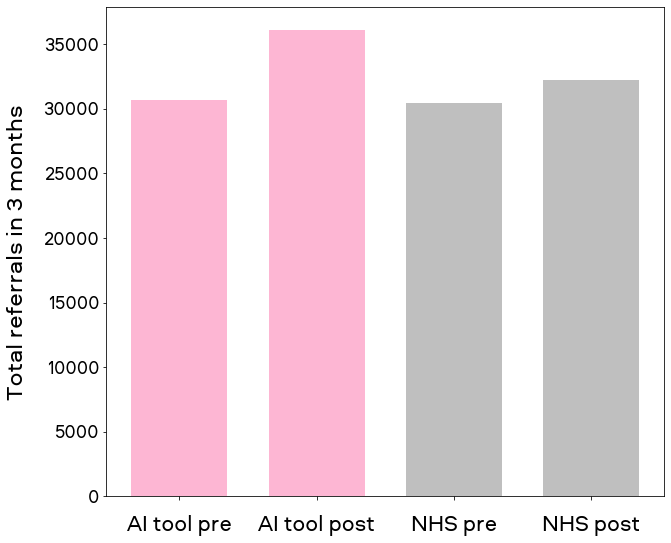

In [65]:
fig, ax = plt.subplots(figsize=(10, 9))

plt.bar([0,1], [pre_tool, post_tool], color = '#fdb6d3', width=0.7)
plt.bar([2,3], [pre_nhs, post_nhs], color = '#bfbfbf',  width=0.7)


plt.xticks([0,1,2,3], ['AI tool pre', 'AI tool post', 'NHS pre', 'NHS post'], fontsize=22, font = my_font)

plt.ylabel('Total referrals in 3 months', fontsize=24, font = my_font, labelpad=15)

ax.tick_params(axis='x', which='major', pad=15)

plt.yticks(fontsize=18, font = my_font)

# plt.ylim(0,47000)


image_format = 'png' # e.g .png, .svg, etc.
image_name = folder_figures_save+'total_referrals.png'

# fig.savefig(image_name, format=image_format, bbox_inches="tight",dpi=1200)


In [66]:
chi2_contingency([[pre_tool, post_tool],[pre_nhs,post_nhs]])

(86.30660757373778,
 1.5409281350670706e-20,
 1,
 array([[31524.33764729, 35235.66235271],
        [29590.66235271, 33074.33764729]]))

In [67]:
print( 'percentage change for the self-referral tool', round(((post_tool - pre_tool)/post_tool)*100,2) )
print('percentage change for nhs', round(((post_nhs-pre_nhs)/post_nhs)*100,2) )

# Demogrphic comparison

In [68]:
# Calculate the total referrals for each subgroup using np.nansum()
ethnicity_total_control_pre = np.nansum(ethnicity_referrals_compare, axis=0)
ethnicity_total_control_post = np.nansum(ethnicity_referrals_post_compare, axis=0)
ethnicity_change_control = [post - pre for post, pre in zip(ethnicity_total_control_post, ethnicity_total_control_pre)]

gender_total_control_pre = np.nansum(gender_referrals_compare, axis=0)
gender_total_control_post = np.nansum(gender_referrals_post_compare, axis=0)
gender_change_control = [post - pre for post, pre in zip(gender_total_control_post, gender_total_control_pre)]

sexuality_total_control_pre = np.nansum(sexuality_referrals_compare, axis=0)
sexuality_total_control_post = np.nansum(sexuality_referrals_post_compare, axis=0)
sexuality_change_control = [post - pre for post, pre in zip(sexuality_total_control_post, sexuality_total_control_pre)]

# Calculate the percentage change for each subgroup
ethnicity_perc_change_control =  [(change / pre) * 100 for change, pre in zip(ethnicity_change_control, ethnicity_total_control_pre)]
gender_perc_change_control =  [(change / pre) * 100 for change, pre in zip(gender_change_control, gender_total_control_pre)]
sexuality_perc_change_control =  [(change / pre) * 100 for change, pre in zip(sexuality_change_control, sexuality_total_control_pre)]

In [69]:
# calculate the percentage change for all ethnic minority groups together
all_ethnic_minority_control_pre = sum(ethnicity_total_control_pre[0][:3],ethnicity_total_control_pre[0][4])
all_ethnic_minority_control_post = sum(ethnicity_total_control_post[0][:3],ethnicity_total_control_post[0][4])
all_ethnic_minority_control_perc_change = ((all_ethnic_minority_control_post - all_ethnic_minority_control_pre)/all_ethnic_minority_control_pre)*100

all_ethnic_minority_tool_pre = sum(ethnicity_total_pre[:3],ethnicity_total_pre[4])
all_ethnic_minority_tool_post = sum(ethnicity_total_post[:3],ethnicity_total_post[4])
all_ethnic_minority_tool_perc_change = ((all_ethnic_minority_tool_post - all_ethnic_minority_tool_pre)/all_ethnic_minority_tool_pre)*100


In [70]:
# define a function to add bar labels with the bar values on top of each bar
def add_bar_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height:.0f}', 
                     xy=(bar.get_x() + bar.get_width() / 2, height), 
                     xytext=(0, 7), 
                     textcoords='offset points',
                     ha='center', 
                     fontsize=20,
                     fontproperties=my_font)

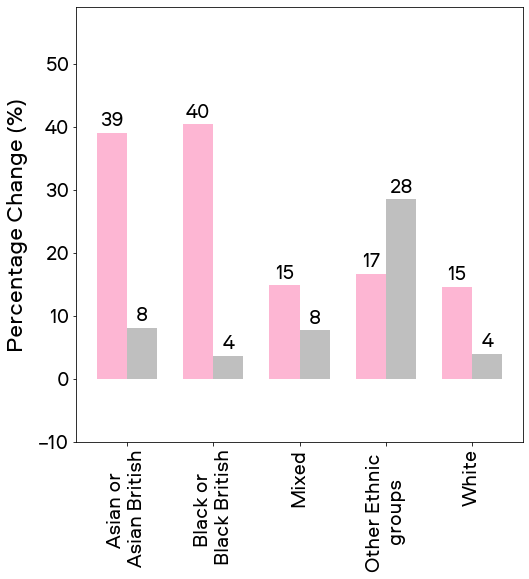

In [71]:
# Define the labels for ethnic groups
ethnic_groups = ['Asian', 'Black', 'Mixed', 'Other', 'White']

# Create the plot
fig, ax = plt.subplots(figsize=(8, 8))

bar_width = 0.35
colors = ['#fdb6d3', '#bfbfbf']

# Plot the bars for  tool groups excluding 'Not Stated'
tool_bars = plt.bar(np.arange(len(ethnic_groups)), ethnicity_perc_change[:3] + ethnicity_perc_change[4:], width=bar_width, color=colors[0], label='Tool Group')
control_bars = plt.bar(np.arange(len(ethnic_groups)) + bar_width, np.concatenate((ethnicity_perc_change_control[0][:3], ethnicity_perc_change_control[0][4:])), width=bar_width, color=colors[1], label='Control Group')

# Add labels, title, and legend
plt.ylabel('Percentage Change (%)', fontsize = 23, font = my_font, labelpad=10)
plt.xticks(np.arange(len(ethnic_groups)) + bar_width / 2, ['Asian or \nAsian British', 'Black or \nBlack British', 'Mixed', 'Other Ethnic \ngroups', 'White'], rotation=90, fontsize = 20, font = my_font)
plt.yticks(fontsize=20, font = my_font)
plt.ylim(-10, 59)

add_bar_labels(tool_bars)
add_bar_labels(control_bars)

# plt.legend(fontsize = 20)

image_format = 'png' # e.g .png, .svg, etc.
# image_name = folder_figures_save+'ethnic_groups_separate_referrals.png'
image_name = folder_figures_save+'ethnic_groups_separate_referrals_matched_for_demographics.png'
# fig.savefig(image_name, format=image_format, bbox_inches="tight",dpi=1200)


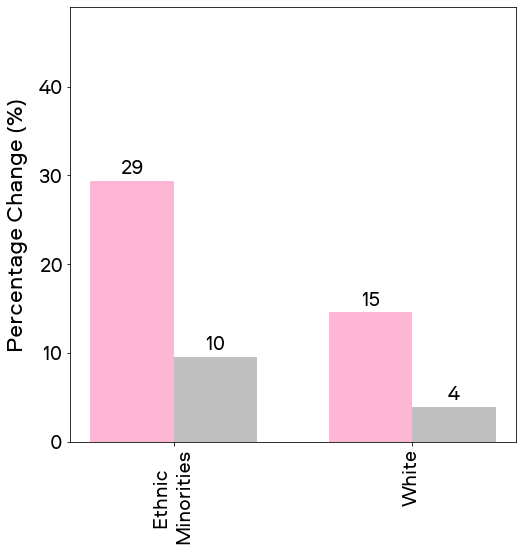

In [72]:
# Create the plot
fig, ax = plt.subplots(figsize=(8, 8))
bar_width = 0.35
colors = ['#fdb6d3', '#bfbfbf']

# Plot the bars for the White group and all ethnic minorities combined
tool_bars = plt.bar(np.arange(2), [all_ethnic_minority_tool_perc_change, ethnicity_perc_change[5]], width=bar_width, color=colors[0], label='Tool Group')
control_bars = plt.bar(np.arange(2) + bar_width, [all_ethnic_minority_control_perc_change, ethnicity_perc_change_control[0][5]], width=bar_width, color=colors[1], label='Control Group')

# Add labels, title, and legend
plt.ylabel('Percentage Change (%)', fontsize = 23, font = my_font, labelpad=10)
plt.xticks(np.arange(2) + bar_width / 2, ['Ethnic \nMinorities', 'White'], rotation=90, fontsize=20, font = my_font)
# plt.legend(fontsize=20)
plt.yticks(fontsize=20, font = my_font)
plt.ylim(0, 49)

add_bar_labels(tool_bars)
add_bar_labels(control_bars)

image_format = 'png' # e.g .png, .svg, etc.
# image_name = folder_figures_save+'ethnic_groups_combined_referrals.png'
image_name = folder_figures_save+'ethnic_groups_combined_referrals_matched_for_demographics.png'

fig.savefig(image_name, format=image_format, bbox_inches="tight",dpi=1200)


In [73]:
# Combine the counts into a contingency table

ethnicity_counts_control_pre = np.array(ethnicity_total_control_pre[0])
ethnicity_counts_tool_pre = ethnicity_total_pre

ethnicity_counts_control_post = np.array(ethnicity_total_control_post[0])
ethnicity_counts_tool_post = ethnicity_total_post

# Create a contingency table
contingency_table = np.array([
    ethnicity_counts_tool_pre,
    ethnicity_counts_tool_post,
    ethnicity_counts_control_pre,
    ethnicity_counts_control_post
]).T  # Transpose to have rows as ethnicity categories and columns as conditions

# Define the row labels (ethnicity categories)
ethnicity_categories = ['Asian', 'Black', 'Mixed', 'Not Stated', 'Other', 'White']

# Create a DataFrame for better visualization
contingency_df_ethnicity = pd.DataFrame(contingency_table, columns=['pre_tool', 'post_tool', 'pre_nhs', 'post_nhs'], index=ethnicity_categories)


In [74]:
change_variable=[]
category=[]
labels=[]
limbic_variable=[]
cat_order= ['Asian', 'Black', 'Mixed', 'Not Stated', 'Other', 'White']


for i in range(len(cat_order)): 
    p=cat_order[i]
    a=np.array(contingency_df_ethnicity.index.values)

    ind=np.where(a==p)[0][0]
    if contingency_df_ethnicity.index.values[ind]!='Not Stated':
        change_variable.append(np.array([0]*int(contingency_df_ethnicity['pre_tool'][ind]))) #pre limbic 0 
        change_variable.append(np.array([1]*int(contingency_df_ethnicity['post_tool'][ind]))) # post limbic 1 

        category.append(np.array([i]*int(contingency_df_ethnicity['pre_tool'][ind]+contingency_df_ethnicity['post_tool'][ind])))
        limbic_variable.append(np.array([1]*int(contingency_df_ethnicity['pre_tool'][ind]+contingency_df_ethnicity['post_tool'][ind]))) # treatment 1

        change_variable.append(np.array([0]*int(contingency_df_ethnicity['pre_nhs'][ind])))
        change_variable.append(np.array([1]*int(contingency_df_ethnicity['post_nhs'][ind])))

        category.append(np.array([i]*int(contingency_df_ethnicity['pre_nhs'][ind]+contingency_df_ethnicity['post_nhs'][ind])))
        limbic_variable.append(np.array([0]*int(contingency_df_ethnicity['pre_nhs'][ind]+contingency_df_ethnicity['post_nhs'][ind]))) #control 0


        labels.append(contingency_df_ethnicity.index.values[ind])
change_variable=np.array(list(deepflatten(change_variable)))
category=np.array(list(deepflatten(category)))
limbic_variable=np.array(list(deepflatten(limbic_variable)))

data_ethnicity=pd.DataFrame({'DV':change_variable, 'demographic':category, 'limbic':limbic_variable})


In [75]:
# Run a logstic regression predicting on a single, inferred, patient level whether the patient referred pre- or 
# post-implementation of the tool  (0 = pre-implementation, 1 = post-implementation). As a predictor variable, 
# use the ethnic group of the individual, assigning the most common group (White) as the reference, 
# whether the individual was in the group using the self-referral tool or control group (0 = control group, 
# 1 = self-referral tool group) and the interaction between these two variables.

log_reg_ethnicity = smf.logit("DV ~ limbic + C(demographic, Treatment(5)) + limbic*C(demographic, Treatment(5))", data=data_ethnicity).fit()
log_reg_ethnicity.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     DV   No. Observations:               115540
Model:                          Logit   Df Residuals:                   115530
Method:                           MLE   Df Model:                            9
Date:                Wed, 11 Oct 2023   Pseudo R-squ.:               0.0007578
Time:                        09:33:37   Log-Likelihood:                -79874.
converged:                       True   LL-Null:                       -79935.
Covariance Type:            nonrobust   LLR p-value:                 7.800e-22
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    0.0385      0.010      3.983      0.000       0.020       0.057
C(demographic, Treatment(5))[T.0]            0.0396      0.032      1.243      0.214      -0.023       0.102
C(demographic, Treatment(5))[T.1]           -0.0031      0.043     -0.071      0.943      -0.088       0.082
C(demographic, Treatment(5))[T.2]            0.0356      0.044      0.808      0.419      -0.051       0.122
C(demographic, Treatment(5))[T.4]            0.2119      0.055      3.879      0.000       0.105       0.319
limbic                                       0.0978      0.013      7.621      0.000       0.073       0.123
limbic:C(demographic, Treatment(5))[T.0]     0.1535      0.053      2.899      0.004       0.050       0.257
limbic:C(demographic, Treatment(5))[T.1]     0.2058      0.070      2.928      0.003       0.068       0.344
limbic:C(demographic, Treatment(5))[T.2]    -0.0339      0.065     -0.522      0.602      -0.161       0.094
limbic:C(demographic, Treatment(5))[T.4]    -0.1941      0.100     -1.947      0.052      -0.389       0.001
============================================================================================================
"""

In [76]:
# Convert to odds ratios
odds_ratios_ethnicity= pd.DataFrame(
    {"OR": log_reg_ethnicity.params,
        "Lower CI": log_reg_ethnicity.conf_int()[0],
        "Upper CI": log_reg_ethnicity.conf_int()[1]}
)
odds_ratios_ethnicity = np.exp(odds_ratios_ethnicity)
odds_ratios_ethnicity

,OR,Lower CI,Upper CI
Intercept,1.039220,1.019733,1.059080
"C(demographic, Treatment(5))[T.0]",1.040343,0.977455,1.107277
"C(demographic, Treatment(5))[T.1]",0.996936,0.916051,1.084962
"C(demographic, Treatment(5))[T.2]",1.036280,0.950411,1.129907
"C(demographic, Treatment(5))[T.4]",1.236074,1.110549,1.375786
limbic,1.102738,1.075350,1.130825
"limbic:C(demographic, Treatment(5))[T.0]",1.165891,1.050977,1.293370
"limbic:C(demographic, Treatment(5))[T.1]",1.228479,1.070395,1.409911
"limbic:C(demographic, Treatment(5))[T.2]",0.966625,0.850892,1.098098
"limbic:C(demographic, Treatment(5))[T.4]",0.823611,0.677454,1.001301


In [77]:
# combine all the minority ethnic groups together to compare them to the White group, and repeat the log regression above

data_ethnicity_minorities_combined = data_ethnicity.copy()
data_ethnicity_minorities_combined['demographic'] = np.where(data_ethnicity_minorities_combined['demographic'] != 5, 1, data_ethnicity_minorities_combined['demographic'])

log_reg_ethnicity_minorities_combined = smf.logit("DV ~ limbic + C(demographic, Treatment(5)) + limbic*C(demographic, Treatment(5))", data=data_ethnicity_minorities_combined).fit()
log_reg_ethnicity_minorities_combined.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     DV   No. Observations:               115540
Model:                          Logit   Df Residuals:                   115536
Method:                           MLE   Df Model:                            3
Date:                Wed, 11 Oct 2023   Pseudo R-squ.:               0.0006068
Time:                        09:33:38   Log-Likelihood:                -79887.
converged:                       True   LL-Null:                       -79935.
Covariance Type:            nonrobust   LLR p-value:                 6.811e-21
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    0.0385      0.010      3.983      0.000       0.020       0.057
C(demographic, Treatment(5))[T.1]            0.0529      0.022      2.398      0.016       0.010       0.096
limbic                                       0.0978      0.013      7.621      0.000       0.073       0.123
limbic:C(demographic, Treatment(5))[T.1]     0.0687      0.035      1.969      0.049       0.000       0.137
============================================================================================================
"""

In [78]:
# Convert to odds ratios
odds_ratios_ethnicity_minorities_combined_= pd.DataFrame(
    {"OR": log_reg_ethnicity_minorities_combined.params,
        "Lower CI": log_reg_ethnicity_minorities_combined.conf_int()[0],
        "Upper CI": log_reg_ethnicity_minorities_combined.conf_int()[1]}
)
odds_ratios_ethnicity_minorities_combined_ = np.exp(odds_ratios_ethnicity_minorities_combined_)
odds_ratios_ethnicity_minorities_combined_

,OR,Lower CI,Upper CI
Intercept,1.039220,1.019733,1.059080
"C(demographic, Treatment(5))[T.1]",1.054328,1.009705,1.100923
limbic,1.102738,1.075350,1.130825
"limbic:C(demographic, Treatment(5))[T.1]",1.071161,1.000329,1.147009


In [79]:
# compare only the Asian groups between services using the self-referral tool vs matched control services

data_asian = data_ethnicity[data_ethnicity['demographic'] == 0]

log_reg_asian= smf.logit("DV ~ limbic", data=data_asian).fit()
log_reg_asian.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     DV   No. Observations:                 6750
Model:                          Logit   Df Residuals:                     6748
Method:                           MLE   Df Model:                            1
Date:                Wed, 11 Oct 2023   Pseudo R-squ.:                0.002582
Time:                        09:33:38   Log-Likelihood:                -4643.5
converged:                       True   LL-Null:                       -4655.5
Covariance Type:            nonrobust   LLR p-value:                 9.420e-07
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0780      0.030      2.574      0.010       0.019       0.137
limbic         0.2513      0.051      4.892      0.000       0.151       0.352
==============================================================================
"""

In [80]:
# Convert to odds ratios
odds_ratios_asian= pd.DataFrame(
    {"OR": log_reg_asian.params,
        "Lower CI": log_reg_asian.conf_int()[0],
        "Upper CI": log_reg_asian.conf_int()[1]}
)
odds_ratios_asian = np.exp(odds_ratios_asian)
odds_ratios_asian

,OR,Lower CI,Upper CI
Intercept,1.081146,1.018785,1.147324
limbic,1.285673,1.162544,1.421843


In [81]:
# compare only the Black groups between services using the self-referral tool vs matched control services

data_black = data_ethnicity[data_ethnicity['demographic'] == 1]

log_reg_black= smf.logit("DV ~ limbic", data=data_black).fit()
log_reg_black.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     DV   No. Observations:                 3630
Model:                          Logit   Df Residuals:                     3628
Method:                           MLE   Df Model:                            1
Date:                Wed, 11 Oct 2023   Pseudo R-squ.:                0.003871
Time:                        09:33:38   Log-Likelihood:                -2496.4
converged:                       True   LL-Null:                       -2506.1
Covariance Type:            nonrobust   LLR p-value:                 1.058e-05
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0354      0.042      0.841      0.400      -0.047       0.118
limbic         0.3036      0.069      4.393      0.000       0.168       0.439
==============================================================================
"""

In [82]:
# Convert to odds ratios
odds_ratios_black= pd.DataFrame(
    {"OR": log_reg_black.params,
        "Lower CI": log_reg_black.conf_int()[0],
        "Upper CI": log_reg_black.conf_int()[1]}
)
odds_ratios_black = np.exp(odds_ratios_black)
odds_ratios_black

,OR,Lower CI,Upper CI
Intercept,1.036036,0.954023,1.125099
limbic,1.354691,1.183101,1.551167


In [83]:
# compare only the Mixed groups between services using the self-referral tool vs matched control services

data_mixed = data_ethnicity[data_ethnicity['demographic'] == 2]

log_reg_mixed= smf.logit("DV ~ limbic", data=data_mixed).fit()
log_reg_mixed.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     DV   No. Observations:                 3975
Model:                          Logit   Df Residuals:                     3973
Method:                           MLE   Df Model:                            1
Date:                Wed, 11 Oct 2023   Pseudo R-squ.:               0.0001822
Time:                        09:33:38   Log-Likelihood:                -2749.5
converged:                       True   LL-Null:                       -2750.0
Covariance Type:            nonrobust   LLR p-value:                    0.3168
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0741      0.043      1.721      0.085      -0.010       0.159
limbic         0.0639      0.064      1.001      0.317      -0.061       0.189
==============================================================================
"""

In [84]:
# Convert to odds ratios
odds_ratios_mixed= pd.DataFrame(
    {"OR": log_reg_mixed.params,
        "Lower CI": log_reg_mixed.conf_int()[0],
        "Upper CI": log_reg_mixed.conf_int()[1]}
)
odds_ratios_mixed = np.exp(odds_ratios_mixed)
odds_ratios_mixed

,OR,Lower CI,Upper CI
Intercept,1.076923,0.989759,1.171763
limbic,1.065934,0.940665,1.207885


In [85]:
# compare only the other ethnic groups between services using the self-referral tool vs matched control services

data_other = data_ethnicity[data_ethnicity['demographic'] == 4]

log_reg_other= smf.logit("DV ~ limbic", data=data_other).fit()
log_reg_other.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     DV   No. Observations:                 1990
Model:                          Logit   Df Residuals:                     1988
Method:                           MLE   Df Model:                            1
Date:                Wed, 11 Oct 2023   Pseudo R-squ.:               0.0003465
Time:                        09:33:38   Log-Likelihood:                -1366.7
converged:                       True   LL-Null:                       -1367.2
Covariance Type:            nonrobust   LLR p-value:                    0.3304
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2504      0.054      4.657      0.000       0.145       0.356
limbic        -0.0963      0.099     -0.974      0.330      -0.290       0.097
==============================================================================
"""

In [86]:
# Convert to odds ratios
odds_ratios_other= pd.DataFrame(
    {"OR": log_reg_other.params,
        "Lower CI": log_reg_other.conf_int()[0],
        "Upper CI": log_reg_other.conf_int()[1]}
)
odds_ratios_other = np.exp(odds_ratios_other)
odds_ratios_other

,OR,Lower CI,Upper CI
Intercept,1.284553,1.156053,1.427335
limbic,0.908228,0.748270,1.102379


In [87]:
# compare all ethnic minority groups between services using the self-referral tool vs matched control services
data_all_minority = data_asian.append(data_other)
data_all_minority = data_all_minority.append(data_mixed)
data_all_minority = data_all_minority.append(data_black)

log_reg_all_minority= smf.logit("DV ~ limbic", data=data_all_minority).fit()
log_reg_all_minority.summary()

/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1780029715.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_all_minority = data_asian.append(data_other)
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1780029715.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_all_minority = data_all_minority.append(data_mixed)
/var/folders/2x/1pj9_k6n35l_s8ygvsr_lq6h0000gn/T/ipykernel_5477/1780029715.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_all_minority = data_all_minority.append(data_black)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     DV   No. Observations:                16345
Model:                          Logit   Df Residuals:                    16343
Method:                           MLE   Df Model:                            1
Date:                Wed, 11 Oct 2023   Pseudo R-squ.:                0.001169
Time:                        09:33:40   Log-Likelihood:                -11268.
converged:                       True   LL-Null:                       -11281.
Covariance Type:            nonrobust   LLR p-value:                 2.811e-07
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0914      0.020      4.606      0.000       0.052       0.130
limbic         0.1665      0.032      5.130      0.000       0.103       0.230
==============================================================================
"""

In [88]:
# Convert to odds ratios
odds_ratios_ethnicity_all_minority= pd.DataFrame(
    {"OR": log_reg_all_minority.params,
        "Lower CI": log_reg_all_minority.conf_int()[0],
        "Upper CI": log_reg_all_minority.conf_int()[1]}
)
odds_ratios_ethnicity_all_minority = np.exp(odds_ratios_ethnicity_all_minority)


In [89]:
# compare only the White group between services using the self-referral tool vs matched control services

data_white = data_ethnicity[data_ethnicity['demographic'] == 5]

log_reg_white= smf.logit("DV ~ limbic", data=data_white).fit()
log_reg_white.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     DV   No. Observations:                99195
Model:                          Logit   Df Residuals:                    99193
Method:                           MLE   Df Model:                            1
Date:                Wed, 11 Oct 2023   Pseudo R-squ.:               0.0004231
Time:                        09:33:40   Log-Likelihood:                -68618.
converged:                       True   LL-Null:                       -68647.
Covariance Type:            nonrobust   LLR p-value:                 2.505e-14
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0385      0.010      3.983      0.000       0.020       0.057
limbic         0.0978      0.013      7.621      0.000       0.073       0.123
==============================================================================
"""

In [90]:
# Convert to odds ratios
odds_ratios_white= pd.DataFrame(
    {"OR": log_reg_white.params,
        "Lower CI": log_reg_white.conf_int()[0],
        "Upper CI": log_reg_white.conf_int()[1]}
)
odds_ratios_white = np.exp(odds_ratios_white)
odds_ratios_white

,OR,Lower CI,Upper CI
Intercept,1.039220,1.019733,1.059080
limbic,1.102738,1.075350,1.130825


## Sexuality analysis

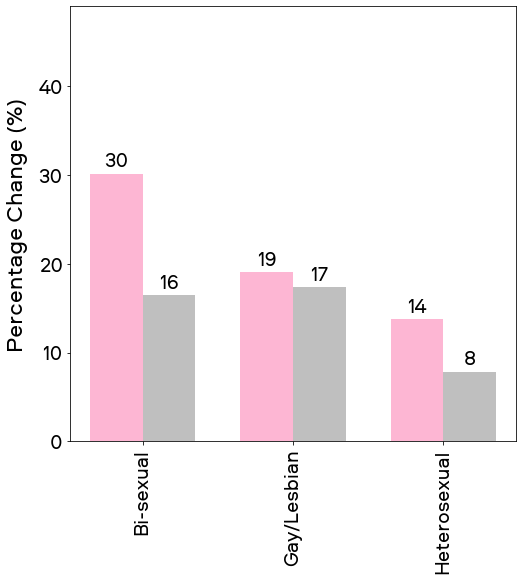

In [91]:
# Define the labels for sexuality groups

sexuality_groups = ['Bi-sexual', 'Gay/Lesbian', 'Heterosexual']

# Create the plot
fig, ax = plt.subplots(figsize=(8, 8))
bar_width = 0.35

# Plot the bars for the  groups - exlcude not stated
tool_bars = plt.bar(np.arange(len(sexuality_groups)), sexuality_perc_change[:3], width=bar_width, color=colors[0], label='Tool Group')
control_bars = plt.bar(np.arange(len(sexuality_groups)) + bar_width, sexuality_perc_change_control[0][:3], width=bar_width, color=colors[1], label='Control Group')


# Add labels, title, and legend
plt.ylabel('Percentage Change (%)', fontsize = 23, font = my_font, labelpad=10)
plt.xticks(np.arange(len(sexuality_groups)) + bar_width / 2, sexuality_groups, rotation=90, fontsize = 20, font = my_font)
# plt.legend(fontsize = 15)
plt.yticks(fontsize=20, font = my_font)
plt.ylim(0, 49)

add_bar_labels(tool_bars)
add_bar_labels(control_bars)

image_format = 'png' # e.g .png, .svg, etc.
# image_name = folder_figures_save+'sexuality_groups_combined_referrals.png'
image_name = folder_figures_save+'sexuality_groups_combined_referrals_matched_for_demographics.png'

# fig.savefig(image_name, format=image_format, bbox_inches="tight",dpi=1200)


In [92]:
# Combine the counts into a contingency table

sexuality_counts_control_pre = np.array(sexuality_total_control_pre[0])
sexuality_counts_tool_pre = sexuality_total_pre

sexuality_counts_control_post = np.array(sexuality_total_control_post[0])
sexuality_counts_tool_post = sexuality_total_post


# Create a contingency table
contingency_table = np.array([
    sexuality_counts_tool_pre,
    sexuality_counts_tool_post,
    sexuality_counts_control_pre,
    sexuality_counts_control_post
]).T  # Transpose to have rows as sexuality categories and columns as conditions

# Define the row labels (sexuality categories)
sexuality_categories = ['Bi-sexual', 'Gay/Lesbian', 'Heterosexual', 'Not Stated']

# Create a DataFrame for better visualization
contingency_df_sexuality = pd.DataFrame(contingency_table, columns=['pre_tool', 'post_tool', 'pre_nhs', 'post_nhs'], index=sexuality_categories)


In [93]:
change_variable=[]
category=[]
labels=[]
limbic_variable=[]
cat_order=['Bi-sexual', 'Gay/Lesbian', 'Heterosexual', 'Not Stated']


for i in range(len(cat_order)): 
    p=cat_order[i]
    a=np.array(contingency_df_sexuality.index.values)

    ind=np.where(a==p)[0][0]
    if contingency_df_sexuality.index.values[ind]!='Not Stated':
        change_variable.append(np.array([0]*int(contingency_df_sexuality['pre_tool'][ind]))) #pre limbic 0 
        change_variable.append(np.array([1]*int(contingency_df_sexuality['post_tool'][ind]))) # post limbic 1 

        category.append(np.array([i]*int(contingency_df_sexuality['pre_tool'][ind]+contingency_df_sexuality['post_tool'][ind])))
        limbic_variable.append(np.array([1]*int(contingency_df_sexuality['pre_tool'][ind]+contingency_df_sexuality['post_tool'][ind]))) # treatment 1

        change_variable.append(np.array([0]*int(contingency_df_sexuality['pre_nhs'][ind])))
        change_variable.append(np.array([1]*int(contingency_df_sexuality['post_nhs'][ind])))

        category.append(np.array([i]*int(contingency_df_sexuality['pre_nhs'][ind]+contingency_df_sexuality['post_nhs'][ind])))
        limbic_variable.append(np.array([0]*int(contingency_df_sexuality['pre_nhs'][ind]+contingency_df_sexuality['post_nhs'][ind]))) #control 0


        labels.append(contingency_df_sexuality.index.values[ind])
change_variable=np.array(list(deepflatten(change_variable)))
category=np.array(list(deepflatten(category)))
limbic_variable=np.array(list(deepflatten(limbic_variable)))

data_sexuality=pd.DataFrame({'DV':change_variable, 'demographic':category, 'limbic':limbic_variable})



In [94]:
# Run a logstic regression predicting on a single, inferred, patient level whether the patient referred pre- or 
# post-implementation of the tool  (0 = pre-implementation, 1 = post-implementation). As a predictor variable, 
# use the sexuality group of the individual, assigning the most common group (heterosexual) as the reference, 
# whether the individual was in the group using the self-referral tool or control group (0 = control group, 
# 1 = self-referral tool group) and the interaction between these two variables.

log_reg_sexuality = smf.logit("DV ~ limbic + C(demographic, Treatment(2)) + limbic*C(demographic, Treatment(2))", data=data_sexuality).fit()
log_reg_sexuality.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     DV   No. Observations:                93495
Model:                          Logit   Df Residuals:                    93489
Method:                           MLE   Df Model:                            5
Date:                Wed, 11 Oct 2023   Pseudo R-squ.:               0.0003110
Time:                        09:33:41   Log-Likelihood:                -64626.
converged:                       True   LL-Null:                       -64646.
Covariance Type:            nonrobust   LLR p-value:                 1.352e-07
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    0.0756      0.011      6.900      0.000       0.054       0.097
C(demographic, Treatment(2))[T.0]            0.0767      0.050      1.542      0.123      -0.021       0.174
C(demographic, Treatment(2))[T.1]            0.0847      0.074      1.143      0.253      -0.060       0.230
limbic                                       0.0531      0.014      3.787      0.000       0.026       0.081
limbic:C(demographic, Treatment(2))[T.0]     0.0582      0.059      0.982      0.326      -0.058       0.174
limbic:C(demographic, Treatment(2))[T.1]    -0.0387      0.098     -0.393      0.695      -0.232       0.154
============================================================================================================
"""

In [95]:
# Convert to odds ratios
odds_ratios_sexuality = pd.DataFrame(
    {"OR": log_reg_sexuality.params,
        "Lower CI": log_reg_sexuality.conf_int()[0],
        "Upper CI": log_reg_sexuality.conf_int()[1]}
)
odds_ratios_sexuality = np.exp(odds_ratios_sexuality)
odds_ratios_sexuality

,OR,Lower CI,Upper CI
Intercept,1.078578,1.055650,1.102004
"C(demographic, Treatment(2))[T.0]",1.079715,0.979444,1.190251
"C(demographic, Treatment(2))[T.1]",1.088389,0.941298,1.258466
limbic,1.054554,1.025961,1.083944
"limbic:C(demographic, Treatment(2))[T.0]",1.059884,0.943681,1.190396
"limbic:C(demographic, Treatment(2))[T.1]",0.962080,0.793204,1.166911


In [96]:
# compare only the bisexual groups between services using the self-referral tool vs matched control services

data_bisexual = data_sexuality[data_sexuality['demographic'] == 0]

log_reg_bisexual= smf.logit("DV ~ limbic", data=data_bisexual).fit()
log_reg_bisexual.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     DV   No. Observations:                 5945
Model:                          Logit   Df Residuals:                     5943
Method:                           MLE   Df Model:                            1
Date:                Wed, 11 Oct 2023   Pseudo R-squ.:               0.0004572
Time:                        09:33:41   Log-Likelihood:                -4079.3
converged:                       True   LL-Null:                       -4081.2
Covariance Type:            nonrobust   LLR p-value:                   0.05337
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1523      0.049      3.141      0.002       0.057       0.247
limbic         0.1113      0.058      1.933      0.053      -0.002       0.224
==============================================================================
"""

In [97]:
# Convert to odds ratios
odds_ratios_bisexual = pd.DataFrame(
    {"OR": log_reg_bisexual.params,
        "Lower CI": log_reg_bisexual.conf_int()[0],
        "Upper CI": log_reg_bisexual.conf_int()[1]}
)
odds_ratios_bisexual = np.exp(odds_ratios_bisexual)
odds_ratios_bisexual

,OR,Lower CI,Upper CI
Intercept,1.164557,1.058944,1.280704
limbic,1.117704,0.998452,1.251200


In [98]:
# compare only the gay/lesbian groups between services using the self-referral tool vs matched control services

data_homosexual = data_sexuality[data_sexuality['demographic'] == 1]

log_reg_homosexual= smf.logit("DV ~ limbic", data=data_homosexual).fit()
log_reg_homosexual.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     DV   No. Observations:                 1725
Model:                          Logit   Df Residuals:                     1723
Method:                           MLE   Df Model:                            1
Date:                Wed, 11 Oct 2023   Pseudo R-squ.:               9.249e-06
Time:                        09:33:41   Log-Likelihood:                -1189.6
converged:                       True   LL-Null:                       -1189.6
Covariance Type:            nonrobust   LLR p-value:                    0.8821
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1603      0.073      2.189      0.029       0.017       0.304
limbic         0.0145      0.097      0.148      0.882      -0.177       0.206
==============================================================================
"""

In [99]:
# Convert to odds ratios
odds_ratios_homosexual = pd.DataFrame(
    {"OR": log_reg_homosexual.params,
        "Lower CI": log_reg_homosexual.conf_int()[0],
        "Upper CI": log_reg_homosexual.conf_int()[1]}
)
odds_ratios_homosexual = np.exp(odds_ratios_homosexual)
odds_ratios_homosexual

,OR,Lower CI,Upper CI
Intercept,1.173913,1.016888,1.355186
limbic,1.014565,0.838123,1.228152


In [100]:
# compare only the heterosexual groups between services using the self-referral tool vs matched control services

data_heterosexual = data_sexuality[data_sexuality['demographic'] == 2]

log_reg_heterosexual= smf.logit("DV ~ limbic", data=data_heterosexual).fit()
log_reg_heterosexual.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     DV   No. Observations:                85825
Model:                          Logit   Df Residuals:                    85823
Method:                           MLE   Df Model:                            1
Date:                Wed, 11 Oct 2023   Pseudo R-squ.:               0.0001208
Time:                        09:33:41   Log-Likelihood:                -59357.
converged:                       True   LL-Null:                       -59364.
Covariance Type:            nonrobust   LLR p-value:                 0.0001524
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0756      0.011      6.900      0.000       0.054       0.097
limbic         0.0531      0.014      3.787      0.000       0.026       0.081
==============================================================================
"""

In [101]:
# Convert to odds ratios
odds_ratios_heterosexual = pd.DataFrame(
    {"OR": log_reg_heterosexual.params,
        "Lower CI": log_reg_heterosexual.conf_int()[0],
        "Upper CI": log_reg_heterosexual.conf_int()[1]}
)
odds_ratios_heterosexual = np.exp(odds_ratios_heterosexual)
odds_ratios_heterosexual

,OR,Lower CI,Upper CI
Intercept,1.078578,1.055650,1.102004
limbic,1.054554,1.025961,1.083944


## Gender analysis

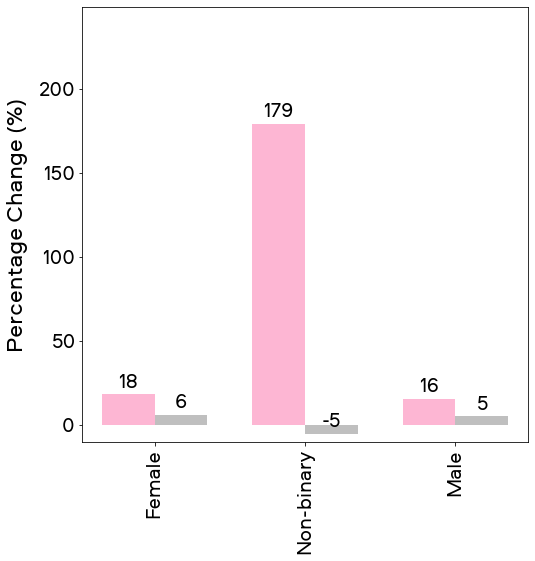

In [102]:
# Define the labels for gender groups

gender_groups = ['Female', 'Indeterminate', 'Male']

# Create the plot
fig, ax = plt.subplots(figsize=(8, 8))
bar_width = 0.35

# Plot the bars for the  groups - exlcude not stated
tool_bars = plt.bar(np.arange(len(gender_groups)), gender_perc_change[:3], width=bar_width, color=colors[0], label='Tool Group')
control_bars = plt.bar(np.arange(len(gender_groups)) + bar_width, gender_perc_change_control[0][:3], width=bar_width, color=colors[1], label='Control Group')


# Add labels, title, and legend
plt.ylabel('Percentage Change (%)', fontsize = 23, font = my_font, labelpad=10)
plt.xticks(np.arange(len(gender_groups)) + bar_width / 2, ['Female', 'Non-binary', 'Male'], rotation=90,fontsize = 20, font = my_font)
# plt.legend(fontsize = 15)
plt.yticks(fontsize=20, font = my_font)
plt.ylim(-10, 249)

add_bar_labels(tool_bars)
add_bar_labels(control_bars)

image_format = 'png' # e.g .png, .svg, etc.
# image_name = folder_figures_save+'gender_groups_combined_referrals.png'
image_name = folder_figures_save+'gender_groups_combined_referrals_matched_for_demographics.png'

fig.savefig(image_name, format=image_format, bbox_inches="tight",dpi=1200)


In [103]:
# Combine the counts into a contingency table

gender_counts_control_pre = np.array(gender_total_control_pre[0])
gender_counts_tool_pre = gender_total_pre

gender_counts_control_post = np.array(gender_total_control_post[0])
gender_counts_tool_post = gender_total_post

# Create a contingency table
contingency_table = np.array([
    gender_counts_tool_pre,
    gender_counts_tool_post,
    gender_counts_control_pre,
    gender_counts_control_post
]).T  # Transpose to have rows as gender categories and columns as conditions

# Define the row labels (gender categories)
gender_categories = ['Female', 'Indeterminate', 'Male', 'Not Stated']

# Create a DataFrame for better visualization
contingency_df_gender = pd.DataFrame(contingency_table, columns=['pre_tool', 'post_tool', 'pre_nhs', 'post_nhs'], index=gender_categories)


In [104]:
change_variable=[]
category=[]
labels=[]
limbic_variable=[]
cat_order= ['Female', 'Indeterminate', 'Male', 'Not Stated']


for i in range(len(cat_order)): 
    p=cat_order[i]
    a=np.array(contingency_df_gender.index.values)

    ind=np.where(a==p)[0][0]
    if contingency_df_gender.index.values[ind]!='Not Stated':
        change_variable.append(np.array([0]*int(contingency_df_gender['pre_tool'][ind]))) #pre limbic 0 
        change_variable.append(np.array([1]*int(contingency_df_gender['post_tool'][ind]))) # post limbic 1 

        category.append(np.array([i]*int(contingency_df_gender['pre_tool'][ind]+contingency_df_gender['post_tool'][ind])))
        limbic_variable.append(np.array([1]*int(contingency_df_gender['pre_tool'][ind]+contingency_df_gender['post_tool'][ind]))) # treatment 1

        change_variable.append(np.array([0]*int(contingency_df_gender['pre_nhs'][ind])))
        change_variable.append(np.array([1]*int(contingency_df_gender['post_nhs'][ind])))

        category.append(np.array([i]*int(contingency_df_gender['pre_nhs'][ind]+contingency_df_gender['post_nhs'][ind])))
        limbic_variable.append(np.array([0]*int(contingency_df_gender['pre_nhs'][ind]+contingency_df_gender['post_nhs'][ind]))) #control 0


        labels.append(contingency_df_gender.index.values[ind])
change_variable=np.array(list(deepflatten(change_variable)))
category=np.array(list(deepflatten(category)))
limbic_variable=np.array(list(deepflatten(limbic_variable)))

data_gender=pd.DataFrame({'DV':change_variable, 'demographic':category, 'limbic':limbic_variable})



In [105]:
# Run a logstic regression predicting on a single, inferred, patient level whether the patient referred pre- or 
# post-implementation of the tool  (0 = pre-implementation, 1 = post-implementation). As a predictor variable, 
# use the ethnic group of the individual, assigning the most common group (females) as the reference, 
# whether the individual was in the group using the self-referral tool or control group (0 = control group, 
# 1 = self-referral tool group) and the interaction between these two variables.

log_reg_gender = smf.logit("DV ~ limbic + C(demographic, Treatment(0)) + limbic*C(demographic, Treatment(0))", data=data_gender).fit()
log_reg_gender.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     DV   No. Observations:               127960
Model:                          Logit   Df Residuals:                   127954
Method:                           MLE   Df Model:                            5
Date:                Wed, 11 Oct 2023   Pseudo R-squ.:               0.0009956
Time:                        09:33:45   Log-Likelihood:                -88406.
converged:                       True   LL-Null:                       -88494.
Covariance Type:            nonrobust   LLR p-value:                 3.463e-36
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    0.0568      0.010      5.826      0.000       0.038       0.076
C(demographic, Treatment(0))[T.1]           -0.1109      0.147     -0.752      0.452      -0.400       0.178
C(demographic, Treatment(0))[T.2]           -0.0087      0.018     -0.499      0.618      -0.043       0.026
limbic                                       0.1108      0.014      8.167      0.000       0.084       0.137
limbic:C(demographic, Treatment(0))[T.1]     0.9699      0.182      5.328      0.000       0.613       1.327
limbic:C(demographic, Treatment(0))[T.2]    -0.0140      0.024     -0.576      0.564      -0.061       0.034
============================================================================================================
"""

In [106]:
# Convert to odds ratios
odds_ratios_gender = pd.DataFrame(
    {"OR": log_reg_gender.params,
        "Lower CI": log_reg_gender.conf_int()[0],
        "Upper CI": log_reg_gender.conf_int()[1]}
)
odds_ratios_gender = np.exp(odds_ratios_gender)
print(odds_ratios_gender)
odds_ratios_gender

,OR,Lower CI,Upper CI
Intercept,1.058478,1.038432,1.078911
"C(demographic, Treatment(0))[T.1]",0.895029,0.670429,1.194871
"C(demographic, Treatment(0))[T.2]",0.991300,0.957854,1.025914
limbic,1.117209,1.087884,1.147325
"limbic:C(demographic, Treatment(0))[T.1]",2.637607,1.846095,3.768480
"limbic:C(demographic, Treatment(0))[T.2]",0.986144,0.940431,1.034079


In [107]:
# compare only the non-binary groups between services using the self-referral tool vs matched control services

data_non_binary = data_gender[data_gender['demographic'] == 1]

log_reg = smf.logit("DV ~ limbic", data=data_non_binary).fit()
log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     DV   No. Observations:                  640
Model:                          Logit   Df Residuals:                      638
Method:                           MLE   Df Model:                            1
Date:                Wed, 11 Oct 2023   Pseudo R-squ.:                 0.04369
Time:                        09:33:45   Log-Likelihood:                -390.67
converged:                       True   LL-Null:                       -408.51
Covariance Type:            nonrobust   LLR p-value:                 2.308e-09
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0541      0.147     -0.368      0.713      -0.342       0.234
limbic         1.0807      0.182      5.953      0.000       0.725       1.437
==============================================================================
"""

In [108]:
# Convert to odds ratios
odds_ratios = pd.DataFrame(
    {"OR": log_reg.params,
        "Lower CI": log_reg.conf_int()[0],
        "Upper CI": log_reg.conf_int()[1]}
)
odds_ratios = np.exp(odds_ratios)
print(odds_ratios)
odds_ratios

,OR,Lower CI,Upper CI
Intercept,0.947368,0.710084,1.263944
limbic,2.946759,2.064523,4.206003


In [109]:
# compare only the female group between services using the self-referral tool vs matched control services

data_female = data_gender[data_gender['demographic'] == 0]

log_reg = smf.logit("DV ~ limbic", data=data_female).fit()
log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     DV   No. Observations:                87320
Model:                          Logit   Df Residuals:                    87318
Method:                           MLE   Df Model:                            1
Date:                Wed, 11 Oct 2023   Pseudo R-squ.:               0.0005525
Time:                        09:33:45   Log-Likelihood:                -60350.
converged:                       True   LL-Null:                       -60384.
Covariance Type:            nonrobust   LLR p-value:                 3.133e-16
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0568      0.010      5.826      0.000       0.038       0.076
limbic         0.1108      0.014      8.167      0.000       0.084       0.137
==============================================================================
"""

In [110]:
# Convert to odds ratios
odds_ratios = pd.DataFrame(
    {"OR": log_reg.params,
        "Lower CI": log_reg.conf_int()[0],
        "Upper CI": log_reg.conf_int()[1]}
)
odds_ratios = np.exp(odds_ratios)
print(odds_ratios)
odds_ratios

,OR,Lower CI,Upper CI
Intercept,1.058478,1.038432,1.078911
limbic,1.117209,1.087884,1.147325


In [111]:
# compare only the male group between services using the self-referral tool vs matched control services

data_male = data_gender[data_gender['demographic'] == 2]

log_reg = smf.logit("DV ~ limbic", data=data_male).fit()
log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     DV   No. Observations:                40000
Model:                          Logit   Df Residuals:                    39998
Method:                           MLE   Df Model:                            1
Date:                Wed, 11 Oct 2023   Pseudo R-squ.:               0.0004216
Time:                        09:33:45   Log-Likelihood:                -27665.
converged:                       True   LL-Null:                       -27677.
Covariance Type:            nonrobust   LLR p-value:                 1.360e-06
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0481      0.015      3.307      0.001       0.020       0.077
limbic         0.0969      0.020      4.830      0.000       0.058       0.136
==============================================================================
"""

In [112]:
# Convert to odds ratios
odds_ratios = pd.DataFrame(
    {"OR": log_reg.params,
        "Lower CI": log_reg.conf_int()[0],
        "Upper CI": log_reg.conf_int()[1]}
)
odds_ratios = np.exp(odds_ratios)
print(odds_ratios)
odds_ratios

,OR,Lower CI,Upper CI
Intercept,1.049269,1.019784,1.079606
limbic,1.101729,1.059259,1.145901


## Quality of matching - compare the pre-implementation period variables  

### Recovery

In [113]:
# Flatten the list of lists and calculate the mean
flattened_list_recovery_control = [item for sublist in recovery_pre_mean_compare for item in sublist]
mean_recovery_pre_control = np.mean(flattened_list_recovery_control)

# tool
flattened_list_recovery_tool = [value for sublist in results['recovery_rates_pre_mean'] for value in sublist]
mean_recovery_pre_tool = np.nanmean(flattened_list_recovery_tool)


In [114]:
mean_recovery_pre_tool

48.642857142857146

In [115]:
mean_recovery_pre_control

45.214285714285715

In [116]:
scipy.stats.ttest_ind(flattened_list_recovery_control, [x for x in flattened_list_recovery_tool if not math.isnan(x)], nan_policy='omit')


Ttest_indResult(statistic=-1.6414751162730539, pvalue=0.11274170168803296)

### Wait times

In [117]:
flattened_list_waittime_control = [item for sublist in waitlines_pre_mean_compare for item in sublist]
mean_waittime_pre_control = np.nanmean(flattened_list_waittime_control)

# tool
flattened_list_waittime_tool = [value for sublist in results['wait_time_mean_pre'] for value in sublist]
mean_waittime_pre_tool = np.nanmean(flattened_list_waittime_tool)

In [118]:
mean_waittime_pre_control

24.409523809523808

In [119]:
mean_waittime_pre_tool

17.70952380952381

In [120]:
scipy.stats.ttest_ind(flattened_list_waittime_control, flattened_list_waittime_tool, nan_policy='omit')


Ttest_indResult(statistic=1.2827718659498772, pvalue=0.21089020802850147)

### Compare the demogrphic composition in the pre period

#### Females

In [121]:
# calculate the % of females for each service in limbic group
flatted_list_females_control = [sublist[0][0] for sublist in gender_referrals_compare]
# calculate the % of femles for each service in control group
flatted_list_females_tool = [item[0] for item in [data['Gender']['Referrals'] for data in results_tool_demographic_pre.values()]]

# t-test 
scipy.stats.ttest_ind(flatted_list_females_control, flatted_list_females_tool, nan_policy='omit')


Ttest_indResult(statistic=-0.03429535581246224, pvalue=0.972903568876232)

In [122]:
np.mean(flatted_list_females_control)

1459.642857142857

In [123]:
np.mean(flatted_list_females_tool)

1481.0714285714287

#### Non-binary

In [124]:
# calculate the % of nonbinary for each service in limbic group
flatted_list_nonbinary_control = [sublist[0][1] for sublist in gender_referrals_compare]
# calculate the % of femles for each service in control group
flatted_list_nonbinary_tool = [item[1] for item in [data['Gender']['Referrals'] for data in results_tool_demographic_pre.values()]]

# t-test 
scipy.stats.ttest_ind(flatted_list_nonbinary_control, flatted_list_nonbinary_tool, nan_policy='omit')


Ttest_indResult(statistic=-0.34585723193303725, pvalue=0.7322329670814155)

In [125]:
np.mean(flatted_list_nonbinary_control)

6.785714285714286

In [126]:
np.mean(flatted_list_nonbinary_tool)

8.571428571428571

#### Males

In [127]:
# calculate the % of males for each service in limbic group
flatted_list_males_control = [sublist[0][2] for sublist in gender_referrals_compare]
# calculate the % of femles for each service in control group
flatted_list_males_tool = [item[2] for item in [data['Gender']['Referrals'] for data in results_tool_demographic_pre.values()]]

# t-test 
scipy.stats.ttest_ind(flatted_list_males_control, flatted_list_males_tool, nan_policy='omit')


Ttest_indResult(statistic=-0.1356741918444884, pvalue=0.8931238365782014)

In [128]:
np.mean(flatted_list_males_control)

659.6428571428571

In [129]:
np.mean(flatted_list_males_tool)

698.2142857142857

### Bi-sexual

In [130]:
# calculate the % of bisexual for each service in limbic group
flatted_list_bisexual_control = [sublist[0][0] for sublist in sexuality_referrals_compare]
# calculate the % of femles for each service in control group
flatted_list_bisexual_tool = [item[0] for item in [data['Sexual Orientation']['Referrals'] for data in results_tool_demographic_pre.values()]]

# t-test 
scipy.stats.ttest_ind(flatted_list_bisexual_control, flatted_list_bisexual_tool, nan_policy='omit')


Ttest_indResult(statistic=-1.398900442043825, pvalue=0.17365941804963336)

In [131]:
np.mean(flatted_list_bisexual_control)

56.42857142857143

In [132]:
np.mean(flatted_list_bisexual_tool)

131.42857142857142

### Gay/lesbian

In [133]:
# calculate the % of homosexual for each service in limhomoc group
flatted_list_homosexual_control = [sublist[0][1] for sublist in sexuality_referrals_compare]
# calculate the % of femles for each service in control group
flatted_list_homosexual_tool = [item[1] for item in [data['Sexual Orientation']['Referrals'] for data in results_tool_demographic_pre.values()]]

# t-test 
scipy.stats.ttest_ind(flatted_list_homosexual_control, flatted_list_homosexual_tool, nan_policy='omit')


Ttest_indResult(statistic=-0.34965002083056873, pvalue=0.7294177190775731)

In [134]:
np.mean(flatted_list_homosexual_control)

24.642857142857142

In [135]:
np.mean(flatted_list_homosexual_tool)

31.785714285714285

### Heterosexual

In [136]:
# calculate the % of heterosexual for each service in limheteroc group
flatted_list_heterosexual_control = [sublist[0][2] for sublist in sexuality_referrals_compare]
# calculate the % of femles for each service in control group
flatted_list_heterosexual_tool = [item[2] for item in [data['Sexual Orientation']['Referrals'] for data in results_tool_demographic_pre.values()]]

# t-test 
scipy.stats.ttest_ind(flatted_list_heterosexual_control, flatted_list_heterosexual_tool, nan_policy='omit')


Ttest_indResult(statistic=-0.8811493332630456, pvalue=0.3863102347225742)

In [137]:
np.mean(flatted_list_heterosexual_control)

1145.357142857143

In [138]:
np.mean(flatted_list_heterosexual_tool)

1754.2857142857142

### Asian or Asian British

In [139]:
# calculate the % of asian for each service in limheteroc group
flatted_list_asian_control = [sublist[0][0] for sublist in ethnicity_referrals_compare]
# calculate the % of femles for each service in control group
flatted_list_asian_tool = [item[0] for item in [data['Ethnicity']['Referrals'] for data in results_tool_demographic_pre.values()]]

# t-test 
scipy.stats.ttest_ind(flatted_list_asian_control, flatted_list_asian_tool, nan_policy='omit')


Ttest_indResult(statistic=0.902960652949256, pvalue=0.37483679640790624)

In [140]:
np.mean(flatted_list_asian_control)

149.64285714285714

In [141]:
np.mean(flatted_list_asian_tool)

71.42857142857143

### Black or Black British

In [142]:
# calculate the % of black for each service in limheteroc group
flatted_list_black_control = [sublist[0][1] for sublist in ethnicity_referrals_compare]
# calculate the % of femles for each service in control group
flatted_list_black_tool = [item[1] for item in [data['Ethnicity']['Referrals'] for data in results_tool_demographic_pre.values()]]

# t-test 
scipy.stats.ttest_ind(flatted_list_black_control, flatted_list_black_tool, nan_policy='omit')


Ttest_indResult(statistic=1.1378560320190354, pvalue=0.26555784243082337)

In [143]:
np.mean(flatted_list_black_control)

79.28571428571429

In [144]:
np.mean(flatted_list_black_tool)

40.714285714285715

### Mixed

In [145]:
# calculate the % of mixed for each service in limheteroc group
flatted_list_mixed_control = [sublist[0][2] for sublist in ethnicity_referrals_compare]
# calculate the % of femles for each service in control group
flatted_list_mixed_tool = [item[2] for item in [data['Ethnicity']['Referrals'] for data in results_tool_demographic_pre.values()]]

# t-test 
scipy.stats.ttest_ind(flatted_list_mixed_control, flatted_list_mixed_tool, nan_policy='omit')


Ttest_indResult(statistic=0.3388506794122953, pvalue=0.7374436933909447)

In [146]:
np.mean(flatted_list_mixed_control)

74.28571428571429

In [147]:
np.mean(flatted_list_mixed_tool)

60.357142857142854

### Other ethnic group

In [148]:
# calculate the % of other for each service in limheteroc group
flatted_list_other_control = [sublist[0][4] for sublist in ethnicity_referrals_compare]
# calculate the % of femles for each service in control group
flatted_list_other_tool = [item[4] for item in [data['Ethnicity']['Referrals'] for data in results_tool_demographic_pre.values()]]

# t-test 
scipy.stats.ttest_ind(flatted_list_other_control, flatted_list_other_tool, nan_policy='omit')


Ttest_indResult(statistic=1.2507346507903783, pvalue=0.22217021452140734)

In [149]:
np.mean(flatted_list_other_control)

43.92857142857143

In [150]:
np.mean(flatted_list_other_tool)

19.285714285714285

### White

In [151]:
# calculate the % of white for each service in limheteroc group
flatted_list_white_control = [sublist[0][5] for sublist in ethnicity_referrals_compare]
# calculate the % of femles for each service in control group
flatted_list_white_tool = [item[5] for item in [data['Ethnicity']['Referrals'] for data in results_tool_demographic_pre.values()]]

# t-test 
scipy.stats.ttest_ind(flatted_list_white_control, flatted_list_white_tool, nan_policy='omit')


Ttest_indResult(statistic=-0.519602705779748, pvalue=0.6077362528611165)

In [152]:
np.mean(flatted_list_white_control)

1502.5

In [153]:
np.mean(flatted_list_white_tool)

1873.9285714285713